# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import athena_utils as athena
import openia_script as ia

In [2]:
projects_id= '72'
var_ia=True

var_ie = None
var_grado = None

In [3]:
today=pd.Timestamp.today().date()

# Querys

In [4]:
def ejecutar_queries_paralelo(queries_dict, max_workers=5):
    """
    Ejecuta múltiples queries de Athena en paralelo.
    
    Args:
        queries_dict (dict): Diccionario donde la clave es el nombre identificador 
                            y el valor es la query SQL
                            Ejemplo: {'cancelaciones': query1, 'asistencias': query2}
        max_workers (int): Número máximo de threads paralelos (default: 5)
    
    Returns:
        dict: Diccionario con los DataFrames resultantes
              Ejemplo: {'cancelaciones': df1, 'asistencias': df2}
    """
    results = {}
    errors = {}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las queries en paralelo
        futures = {
            executor.submit(athena.run_athena_query_auto, query, name): name 
            for name, query in queries_dict.items()
        }
        
        # Recoger resultados según vayan terminando
        for future in as_completed(futures):
            query_name = futures[future]
            try:
                df = future.result()
                results[query_name] = df
                print(f"✅ {query_name}: {len(df)} filas obtenidas")
            except Exception as e:
                errors[query_name] = str(e)
                print(f"❌ {query_name}: Error - {e}")
    
    # Reportar resumen
    print(f"\n📊 Resumen: {len(results)}/{len(queries_dict)} queries completadas exitosamente")
    
    if errors:
        print(f"⚠️  Queries con error: {list(errors.keys())}")
    
    return results

In [5]:
query_proyectos=f'''

SELECT 
    p.id AS proyecto_id,
    p.name AS proyecto_nombre,
    p.status AS estado,
    p.type AS tipo_canal,
    p.operation_type AS tipo_operacion,
    p.format AS formato,
    p.seat_sold as inscritos_vendidos,
    p.winning_date as fecha_de_la_firma,
    p.operative_start_date AS fecha_inicio_operativo,
    p.operative_end_date AS fecha_fin_operativo,
    date_diff('week', p.operative_start_date, p.operative_end_date) AS duracion_semanas,
    p.description AS descripcion,
    p.comment AS comentario,
    p.gender_focus AS enfoque_genero,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS organizaciones,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.organization_type), ', ') AS tipos_organizacion,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT c.name), ', ') AS paises,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS tipos_programa
FROM 
    datalake.projects p
    LEFT JOIN datalake.project_organization_association poa ON p.id = poa.project_id
    LEFT JOIN datalake.organizations o ON poa.organization_id = o.id
    LEFT JOIN datalake.countries c ON o.country_id = c.id
    LEFT JOIN datalake.project_program_type_association ppta ON p.id = ppta.project_id
    LEFT JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
WHERE 
    p.id IN ({projects_id})
    
GROUP BY 
    p.id,
    p.name,
    p.status,
    p.type,
    p.mode,
    p.operation_type,
    p.complex_level,
    p.format,
    p.seat_sold,
    p.winning_date,
    p.operative_start_date,
    p.operative_end_date,
    p.description,
    p.comment,
    p.gender_focus
ORDER BY 
    p.id

'''

In [6]:
query_cancelaciones= f'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS org_names
    FROM datalake.project_organization_association poa
    JOIN datalake.organizations o ON poa.organization_id = o.id
    GROUP BY poa.project_id
),
cte_ProgramType AS (
    SELECT
        ppta.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS program_types
    FROM datalake.project_program_type_association ppta
    JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
    GROUP BY ppta.project_id
),
base AS (
    SELECT
        DISTINCT
        p.id AS projectsID,
        p.name AS "Proyecto",
        COALESCE(p.type, 'B2C') AS "Canal",
        pt.program_types AS "Tipo de programa",
        o.org_names AS "Organización",
        (CASE WHEN ee.institution IS NULL THEN ei.name ELSE ee.institution END) AS institucion,
        (CASE WHEN ee.group_section IS NULL THEN rr.college_group ELSE ee.group_section END) AS seccion,
        ee.career AS career,
        rr.id AS room,
        rr.name AS "Room Name",
        CONCAT('https://backoffice.crackthecode.la/dashboard/rooms/', CAST(rr.id AS VARCHAR)) AS "Link Room",
        rs.id AS sesionID,
        rs.session_number AS sesion,
        ee.grade AS grado,
        (CASE WHEN rs.cancellation_reason_id IS NULL THEN 36 ELSE rs.cancellation_reason_id END) AS reasonID,
        (CASE WHEN rc.name IS NULL THEN 'N/A' ELSE rc.name END) AS Motivo,
        rs.start_date AS "Fecha",
        rs.start_time AS Hora,
        SUBSTR(rs.start_time, 1, 2) AS "Hora Agrupada",
        DATE_TRUNC('week', rs.start_date) AS ordenSemana,
        CONCAT(
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date), '%d/%m'),
            '-',
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date) + INTERVAL '6' DAY, '%d/%m')
        ) AS semana,
        DATE_FORMAT(rs.start_date, '%W') AS dia,
        rs.state AS state,
        rs.risk_cancellation AS Riesgo,
        CONCAT(au.last_name, ', ', au.first_name) AS profesor
    FROM
        datalake.room_roomsessions rs
        LEFT JOIN datalake.room_room rr ON rs.room_id = rr.id
        JOIN datalake.enrollment_enrolment ee ON rr.id = ee.room_id AND ee.b2b_project_id IS NOT NULL
        LEFT JOIN datalake.projects p ON (ee.b2b_project_id = p.id OR p.id = rr.project_b2b_id)
        LEFT JOIN cte_Organization o ON p.id = o.project_id
        LEFT JOIN cte_ProgramType pt ON p.id = pt.project_id
        LEFT JOIN datalake.account_user au ON rr.teacher_id = au.id
        LEFT JOIN datalake.catalog_reasonsessioncancellation rc ON (
            (CASE WHEN (rs.state = 'false' AND rs.cancellation_reason_id IS NULL) THEN 36 ELSE rs.cancellation_reason_id END) = rc.id
        )
        LEFT JOIN datalake.educational_institution ei ON ei.id = rr.educational_institution_id
    ORDER BY
        DATE_TRUNC('week', rs.start_date) ASC
)
SELECT *
FROM base
WHERE
    NOT (state = 'false' AND projectsID IN (19, 14) AND (("Fecha" BETWEEN DATE '2024-06-17' AND DATE '2024-07-05') OR ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14')))
    AND
    NOT (state = 'false' AND projectsID IN (47, 48, 56) AND ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14'))
    AND
    (reasonID NOT IN (33, 34, 35) OR reasonID IS NULL)
    
    and projectsID IN ({projects_id})
    
    ;


'''

In [7]:
query_asistencias=f'''

select distinct 
aa.id as attendance_id, 
aa.object_id, 
aa.content_type_id, 
CASE WHEN aa.content_type_id = 8 THEN 'Alumno' WHEN aa.content_type_id = 6 THEN 'Profesor CTC' when aa.content_type_id = 276 then 'Profesor IED' END as content_definition,
CASE WHEN aa.content_type_id = 8 THEN concat(ss.first_name,' ',ss.last_name) ELSE 'NO ES ALUMNO, ES PROFE' END as student_name,
ss.id as student_id,
ss.email as email_student,
ss.doc_type as tipo_documento,
ss.doc_number,
aa.room_id,
concat('https://backoffice.crackthecode.la/dashboard/rooms/', cast(aa.room_id as varchar)) link_room,
aa.room_session_id, 
rrs.start_date,
CASE 
    WHEN cast(aa.status as varchar) = '0' THEN '-'
    WHEN cast(aa.status as varchar) = '1' THEN 'A'
    WHEN cast(aa.status as varchar) = '2' THEN 'T'
    WHEN cast(aa.status as varchar) = '3' THEN 'F'
    WHEN cast(aa.status as varchar) = '4' THEN 'J'
    WHEN cast(aa.status as varchar) = '5' THEN 'R'
    WHEN cast(aa.status as varchar) = '6' THEN 'MR'
         WHEN cast(aa.status as varchar) = '7' THEN 'N/A'
    ELSE cast(aa.status as varchar)
END as attendance_status,
ee.institution, 
try_cast(ee.grade as integer) as grade, 
    CASE
        WHEN ee.state = 'abandoned' THEN 'Abandono'
        WHEN ee.state = 'cancel' THEN 'Cancelado'
        WHEN ee.state = 'done' THEN 'Activo'
        WHEN ee.state = 'inactive' THEN 'Inactivo'
        WHEN ee.state = 'risk' THEN 'En Riesgo'
        ELSE ee.state
    END AS state,
rr.name as room_name,
ee.b2b_project_id,
p.name,
rr.course_mdl_id

from datalake.attendance_attendance as aa 
left join datalake.enrollment_enrolment as ee on ee.room_id = aa.room_id and aa.object_id = ee.student_id
left join datalake.room_roomsessions as rrs on rrs.id = aa.room_session_id 
left join datalake.room_room as rr on rr.id = aa.room_id
left join datalake.student_student as ss on ss.id = aa.object_id
LEFT JOIN datalake.projects p ON (p.id = ee.b2b_project_id)

where 
    aa.content_type_id in (8,6) 
    and ee.b2b_project_id is not null


and rrs.start_date < current_date -- fecha desde donde nos enviaron la data retroactiva
and rrs.state = 'true'
and ee.state not in ('cancel', 'abandoned')

and ee.b2b_project_id IN ({projects_id})

'''

In [8]:
query_calificaciones = f''' 

WITH

  nota_final AS (
   SELECT
     userid
   , courseid
   , CAST(finalgrade AS DECIMAL(10, 2)) nota_final_ponderada
   FROM
     (
      SELECT
        *
      , ROW_NUMBER() OVER (PARTITION BY userid, courseid ORDER BY finalgrade DESC NULLS LAST) rn
      FROM
        datalake.moodle_user_grades
      WHERE (itemtype = 'course')
   )  t
   WHERE (rn = 1)
) 

SELECT
  CONCAT(ss.first_name, ' ', ss.last_name) nombre_completo
, ss.id student_id
, mug.courseid moodle_course_id
, mug.itemname nombre_actividad
, mug.uniqueid id_actividad
, CAST(mug.finalgrade AS DECIMAL(10, 2)) nota_obtenida
, mug.aggregationweight ponderacion
, mug.aggregationstatus
, mug.itemtype
, rr.project_b2b_id project_id
, nf.nota_final_ponderada
, ei.name institution
, rr.college_grade grade
, rr.college_group section
, CONCAT(rr.college_grade, COALESCE(concat('-', rr.college_group), '')) grade_section
, mce.tag activity_tag
, lc.course_base_mdl_id padre_moodle_course_id

FROM
  ((((((((datalake.moodle_user_grades mug
INNER JOIN datalake.student_student ss ON (ss.user_mdl_id = mug.userid))
INNER JOIN datalake.room_room rr ON (rr.course_mdl_id = mug.courseid))
LEFT JOIN nota_final nf ON ((nf.userid = mug.userid) AND (nf.courseid = mug.courseid)))
LEFT JOIN datalake.educational_institution ei ON (ei.id = rr.educational_institution_id))
LEFT JOIN datalake.moodle_course_evaluations mce ON (mce.unique_id = mug.uniqueid))
LEFT JOIN datalake.learning_group lg ON (lg.id = rr.group_id))
LEFT JOIN datalake.learning_course lc ON (lc.id = lg.course_id))
LEFT JOIN datalake.enrollment_enrolment ee ON ((ee.student_id = ss.id) AND (rr.id = ee.room_id) AND (ee.b2b_project_id = rr.project_b2b_id)))

WHERE 
  (NOT (lower(ee.state) IN ('inactive', 'cancel', 'abandoned', 'inactivo')))
  and itemtype='course'
  and ee.b2b_project_id IN ({projects_id})

ORDER BY nombre_completo ASC, mug.courseid ASC, mug.itemtype ASC



'''

In [9]:
query_alumnos = f'''
select distinct
    p.id as project_id,
    p.name as proyecto,
    ss.id as ID, 
    concat(ss.last_name, ', ', ss.first_name) as Nombre_Completo,
    ss.email as Email,
    ss.phone_number as Telefono,
    ss.doc_type as tipo_documento,
    ss.doc_number as documento,
    ee.institution as Institucion,
    ee.grade as grado,
    ee.group_section as seccion,
    ee.room_id as Salon,
    case 
        when ss.gender='male' then 'Masculino'
        when ss.gender='female' then 'Femenino'
        when ss.gender='unspecified' then 'Otros'
        else 'Otros' end as Genero,
    DATE_DIFF('year', ss.birthdate, p.operative_start_date) as Edad,
    case when ((ee.state <> 'cancel') and (ee.state <> 'inactive')) then 'Activo' else 'Inactivo' end as Status,
	COALESCE(MAX(CASE WHEN ceq.tag = 'estrato_socioeconomico' THEN cer.answer END), 'Sin información') AS estrato_socioeconomico,
	COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'etnia' THEN cer.answer END) FILTER (WHERE ceq.tag = 'etnia'), ';'), 'Sin información') AS etnia,
    CASE 
        WHEN SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) = 0 THEN '1- Solo usan escritorio'
        WHEN SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) = 0 THEN '5- Solo usan celular'
        WHEN (SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '2- Mayoritariamente usan escritorio'
        WHEN (SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '4- Mayoritariamente usan celular'
        ELSE '3- Usan ambos dispositivos'
        END AS dispositivo,
    COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'dispositivos' THEN cer.answer END) FILTER (WHERE ceq.tag = 'dispositivos'), ';'), 'Sin información') AS dispositivo_personal
	
from
    datalake.enrollment_enrolment ee
    left join datalake.student_student ss on ss.id=ee.student_id
    left join datalake.projects p on p.id=ee.b2b_project_id
	left join datalake.moodle_enrollment me on me.moodle_id=ss.user_mdl_id
	LEFT JOIN datalake.moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   	LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   	LEFT JOIN datalake.moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
    LEFT JOIN datalake.moodle_session_device msd ON msd.userid=ss.user_mdl_id and msd.ip is not null

where
    p.id in ({projects_id})
    and ee.state <> 'cancel' and ee.state <> 'inactive'

group by
	p.id,
    p.name,
    ss.id,
    ss.last_name,
    ss.first_name,
    ss.email,
    ss.phone_number,
    ss.doc_type,
    ss.doc_number,
    ee.institution,
    ee.grade,
    ee.group_section,
    ee.room_id,
    ss.gender,
    ss.birthdate,
    p.operative_start_date,
    ee.state
'''

In [10]:
query_satisfaccion = rf'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.organization_type), ', ') AS org_types,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.business_owner), ', ') AS org_owners,
        ARRAY_JOIN(
            ARRAY_AGG(
                DISTINCT CONCAT(CAST(o.id AS VARCHAR), ': ', o.name)
            ),
            ', '
        ) AS org_names,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT c.name), ', ') AS org_pais
    FROM
        datalake.project_organization_association poa
        JOIN datalake.organizations o ON poa.organization_id = o.id
        JOIN datalake.countries c ON o.country_id = c.id
    GROUP BY
        poa.project_id
),
-- CTE principal: Construye la base con información del estudiante, respuesta, evaluación y proyecto
base AS (
    SELECT DISTINCT
        -- Información de usuario y estudiante
        me.moodle_id AS moodle_user_id,
        me.role AS moodle_user_role,
        ss.id AS student_id,
        CONCAT(ss.first_name, ' ', ss.last_name) AS student_name,
        ee.institution AS educative_institution,
        ee.grade AS grade,
        DATE_DIFF('year', ss.birthdate, p.operative_start_date) AS age,
        CASE (
            CASE
                WHEN ss.country IS NOT NULL THEN ss.country
                ELSE au.country
            END
        )
            WHEN 'AR' THEN 'Argentina'
            WHEN 'BO' THEN 'Bolivia'
            WHEN 'CL' THEN 'Chile'
            WHEN 'CO' THEN 'Colombia'
            WHEN 'CR' THEN 'Costa Rica'
            WHEN 'EC' THEN 'Ecuador'
            WHEN 'ES' THEN 'España'
            WHEN 'MX' THEN 'México'
            WHEN 'PA' THEN 'Panamá'
            WHEN 'PY' THEN 'Paraguay'
            WHEN 'PE' THEN 'Perú'
            WHEN 'UY' THEN 'Uruguay'
            WHEN 'VE' THEN 'Venezuela'
            WHEN 'OT' THEN 'Otros'
            ELSE (
                CASE
                    WHEN ss.country IS NOT NULL THEN ss.country
                    ELSE au.country
                END
            )
        END AS pais,
        o.org_names AS organization_name,
        o.org_types AS organization_type,
        p.id AS project_id,
		p.internal_name,
        p.name AS project_name,
        p.alliance_start_date,
        ce.course_id AS moodle_course_id,
        rr.id AS room_id,
        rr.name AS room_name,
        rr.teacher_id,
        ce.unique_id AS evaluation_unique_id,
        ce.name AS evaluation_name,
        cer2.attempt_time_finish AS response_time_finished,
        cer2.attempt_state,
        cer2.attempt_id,
        ceq.name AS question_name,
        ceq.question_id,
        ceq.question_name AS question,
        cer2.answer,
        cer2.right_answer,
        ceq.tag AS tag_question,
        -- Transformación de la respuesta a valor numérico
        CASE
            WHEN ceq.tag IN (
                'experiencia_socioocupacional',
                'conocimiento_socioocupacional',
                'contenido_socioocupacional',
                'recursos_socioocupacional',
                'experiencia_programa',
                'afirmaciones_docente',
                'conocimiento_docente',
                'contenido_programa',
                'tiempo_clase',
                'plataforma_campus',
                'uso_plataforma_campus',
                'entrega_trabajos_campus',
                'confianza_uso_academico',
                'confianza_uso_personal',
                'confianza_uso_laboral',
                'recomendacion_programa',
                'material_asincrono_AOE',
                'contenido_asincrono_AOE',
                'recursos_plataforma_campus'
            )
            AND regexp_extract(cer2.answer, '([0-9]+(?:\.[0-9]+)?)', 1) IS NOT NULL THEN CAST(
                regexp_extract(cer2.answer, '([0-9]+(?:\.[0-9]+)?)', 1) AS DOUBLE
            )
            ELSE NULL
        END AS answer_numeric,
        -- Clasificación del módulo
        CASE
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*1|paso\s*1') THEN 'Módulo 1'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*2|paso\s*2') THEN 'Módulo 2'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*3|paso\s*3') THEN 'Módulo 3'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*4|paso\s*4') THEN 'Módulo 4'
            WHEN REGEXP_LIKE(ce.name, '(?i)final|de\s*salida') THEN 'Salida/Final'
        END AS modulo,
        -- Análisis de sentimiento
        sa.sentiment_analysis,
        CAST(sa.sentiment_score AS DOUBLE) AS sentiment_score,
        -- Clasificación temática de la pregunta
        CASE
            WHEN ceq.tag IN (
                'experiencia_socioocupacional',
                'detalle_socioocupacional',
                'conocimiento_socioocupacional',
                'contenido_socioocupacional',
                'detalle_contenido_ocupacional',
                'recursos_socioocupacional'
            ) THEN 'socio_ocupacional'
            
            WHEN ceq.tag = 'afirmaciones_docente' AND LOWER(ceq.question_text) LIKE '%docente%' THEN 'afirmaciones_docente'

            WHEN ceq.tag IN ('contenido_programa', 'detalle_contenido_programa') THEN 'contenido'
            WHEN ceq.tag IN ('experiencia_programa', 'detalle_programa') THEN 'programa'
            WHEN ceq.tag IN ('conocimiento_docente', 'detalle_conocimiento_docente') THEN 'docente ctc'
            WHEN ceq.tag IN ('detalle_plataforma_campus', 'plataforma_campus') THEN 'aula virtual'
            WHEN ceq.tag IN (
                'uso_plataforma_campus',
                'entrega_trabajos_campus',
                'recursos_plataforma_campus'
            ) THEN 'aula_virtual_extra'
            WHEN ceq.tag IN ('recomendacion_programa', 'detalle_recomendacion_programa') THEN 'nps'
            WHEN ceq.tag = 'confianza_uso_academico' THEN 'confianza academica'
            WHEN ceq.tag = 'confianza_uso_personal' THEN 'confianza personal'
            WHEN ceq.tag = 'confianza_uso_laboral' THEN 'confianza laboral'
            WHEN ceq.tag = 'tiempo_clase' THEN 'tiempo'
            WHEN ceq.tag IN ('comentario_adicional_general') THEN 'no aplica'
            ELSE 'sin variable'
        END AS variable,
        -- Identificador único por respuesta
        CONCAT(
            CAST(p.id AS VARCHAR),
            CAST(ss.id AS VARCHAR),
            ce.unique_id
        ) AS identificador_de_respuesta_unica,
        'Share' AS Share,
        -- Clasificación general de la encuesta
        CASE
            WHEN ce.tag = 'cuestionario de satisfacción final' THEN 'Encuesta Final'
            WHEN ce.tag = 'cuestionario de satisfacción modular' THEN CASE
                WHEN REGEXP_LIKE(TRIM(ce.name), '(?i)\bintermedi[oa]\b') THEN 'Encuesta Intermedia'
                WHEN REGEXP_LIKE(TRIM(ce.name), '(?i)\d+') THEN CONCAT(
                    'Encuesta ',
                    REGEXP_EXTRACT(TRIM(ce.name), '(?i)(?:.*?)(\d+)', 1)
                )
                ELSE 'Encuesta'
            END
        END AS Encuesta,
        p.type
    FROM
        datalake.moodle_enrollment me
        LEFT JOIN datalake.moodle_course_evaluations ce ON me.course_id = ce.course_id
        LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON ce.unique_id = ceq.unique_id
        LEFT JOIN datalake.moodle_course_evaluation_responses cer2 ON (
            cer2.unique_id = ce.unique_id
            AND ceq.question_id = cer2.question_id
            AND me.moodle_id = cer2.moodle_id
            AND ce.type <> 'assign'
        )
        INNER JOIN datalake.room_room rr ON rr.course_mdl_id = me.course_id
        LEFT JOIN datalake.student_student ss ON ss.user_mdl_id = me.moodle_id
        LEFT JOIN datalake.account_user au ON (au.id = ss.guardian_id)
        LEFT JOIN datalake.room_room_students rrs ON rrs.student_id = ss.id
        AND rrs.room_id = rr.id
        LEFT JOIN datalake.enrollment_enrolment ee ON (
            (
                ee.group_id = rr.group_id
                OR ee.room_id = rr.id
            )
            AND ee.student_id = ss.id
            AND ee.state <> 'cancel'
        )
        LEFT JOIN datalake.projects p ON p.id = ee.b2b_project_id
        LEFT JOIN cte_Organization o ON o.project_id = p.id
        LEFT JOIN datalake.sentiment_analysis sa ON (
            sa.moodle_id = cer2.moodle_id
            AND sa.unique_id = cer2.unique_id
            AND sa.question_id = cer2.question_id
        )
    WHERE
        me.role = 'student'
        AND cer2.answer IS NOT NULL
        AND (
            YEAR(p.operative_start_date) >= 2024
            OR YEAR(p.operative_end_date) >= 2024
        )
        AND TRIM(LOWER(cer2.answer)) NOT IN ('no answer')
        AND ee.state NOT IN ('cancel', 'inactive')
        AND (
            ceq.question_name <> 'label'
            OR ceq.question_name IS NULL
        )
        AND UPPER(ce.name) NOT LIKE '%DOCENTE%'
        AND ce.tag IN (
            'cuestionario de satisfacción modular',
            'cuestionario de satisfacción final'
        )
        and ee.b2b_project_id IN ({projects_id})

    ORDER BY
        project_id ASC,
        student_id ASC,
        evaluation_unique_id ASC,
        Encuesta ASC,
        question_id ASC
)

-- Resultado final: selecciona desde el CTE base sin escalar
SELECT DISTINCT
    moodle_user_id,
    moodle_user_role,
    pais,
    student_id,
    student_name,
    educative_institution,
    grade,
    age,
    organization_name,
    organization_type,
    project_id,
	internal_name,
    project_name,
    moodle_course_id,
    room_id,
    room_name,
    teacher_id,
    evaluation_unique_id,
    evaluation_name,
    tag_question,
    response_time_finished,
    attempt_state,
    attempt_id,
    question_name,
    question_id,
    question,
    answer,
    right_answer,
    answer_numeric,
    modulo,
    sentiment_analysis,
    sentiment_score,
    variable,
    identificador_de_respuesta_unica,
    Share,
    Encuesta,
    type
FROM
    base
WHERE
    variable <> 'sin variable'
    AND answer IS NOT NULL
    AND TRIM(LOWER(answer)) <> 'no answer'
    
'''

In [11]:
query_satisfaccion_profesores = rf'''

WITH usuarios_ie AS (
    SELECT DISTINCT 
        at.user_id
    FROM 
        datalake.room_roomauxiliarteacher AS rat
    JOIN 
        datalake.account_teacher AS at ON rat.teacher_id = at.id
    WHERE 
        at.user_id IS NOT NULL
),
profesores_ie_por_sala AS (
    SELECT
        rrata.room_id,
        array_join(array_agg(DISTINCT CONCAT(rrat.name, ' ', rrat.last_name)), ', ') AS profesores_ie_asociados_nombres
    FROM
        datalake.room_roomauxiliarteacheraccess AS rrata
    JOIN
        datalake.room_roomauxiliarteacher AS rrat ON rrata.teacher_id = rrat.id
    GROUP BY
        rrata.room_id
),
contextos_por_proyecto AS (
    WITH contextos_por_profesor AS (
        SELECT rrs.teacher_id AS user_id, rrs.room_id
        FROM datalake.room_roomsessions AS rrs
        
        UNION
        
        SELECT at.user_id, rrata.room_id
        FROM datalake.room_roomauxiliarteacheraccess AS rrata
        JOIN datalake.room_roomauxiliarteacher AS rat ON rrata.teacher_id = rat.id
        JOIN datalake.account_teacher AS at ON rat.teacher_id = at.id
        WHERE at.user_id IS NOT NULL
    )
    SELECT
        ctx.user_id,
        p.id AS project_id,
        p.name AS project_name,
        p.type AS project_type,
        p.operative_start_date,
        p.operative_end_date,
        array_join(array_agg(DISTINCT enr.institution), ';') AS lista_instituciones,
        array_join(array_agg(DISTINCT enr.grade), ';') AS lista_grados,
        array_join(array_agg(DISTINCT pies.profesores_ie_asociados_nombres), ';') AS lista_profesores_ie,
        array_join(array_agg(DISTINCT o.name), ';') AS organization_names,
        array_join(array_agg(DISTINCT cbpt.name), ';') AS program_type_names,
        array_join(array_agg(DISTINCT ao.name), ';') AS ofertas_academicas
    FROM 
        contextos_por_profesor AS ctx
    LEFT JOIN 
        datalake.room_room AS r ON ctx.room_id = r.id
    LEFT JOIN (
        SELECT DISTINCT room_id, b2b_project_id, institution, grade
        FROM datalake.enrollment_enrolment
    ) AS enr ON r.id = enr.room_id
    LEFT JOIN 
        datalake.projects AS p ON enr.b2b_project_id = p.id
    LEFT JOIN 
        profesores_ie_por_sala AS pies ON ctx.room_id = pies.room_id
    LEFT JOIN 
        datalake.project_organization_association AS poa ON p.id = poa.project_id
    LEFT JOIN 
        datalake.organizations AS o ON poa.organization_id = o.id
    LEFT JOIN 
        datalake.project_program_type_association AS ppta ON p.id = ppta.project_id
    LEFT JOIN 
        datalake.catalog_b2bprogramtype AS cbpt ON ppta.program_type_id = cbpt.id

    left join  datalake.learning_group as lg on lg.id = r.group_id 
    left join  datalake.learning_course AS lc  on lc.id = lg.course_id
    LEFT JOIN  datalake.academic_offer AS ao ON lc.academic_offer_id = ao.id
    LEFT JOIN  datalake.academic_offer_projects AS aop ON aop.academicoffer_id = ao.id and p.id = aop.projectb2b_id

    WHERE 
        p.id IS NOT NULL
    GROUP BY
        ctx.user_id, p.id, p.name, p.type, p.operative_start_date, p.operative_end_date
),

base_encuesta AS (
    SELECT
        sr.moodle_id,
        sr.question_id,
        sr.answer,
        sr.response_id,
        sr.object_name AS plan_estudio,
        TRY_CAST(sr.answer AS DECIMAL(10, 2)) AS answer_numeric,
        sr.attempt_time_finish,
        sq.question_text,
        sf.form_name
    FROM
        datalake.survey_responses AS sr
    JOIN
        datalake.survey_forms AS sf ON sr.unique_id = sf.unique_id
    LEFT JOIN
        datalake.survey_questions AS sq ON sr.question_id = sq.question_id
    WHERE
        LOWER(sf.form_name) LIKE '%satisf%'
)
SELECT
    be.response_id,
    be.form_name,
    be.question_id,
    be.question_text,
    be.plan_estudio,
    be.answer,
    be.answer_numeric,
    be.attempt_time_finish AS survey_completion_date,
    
    au.id AS user_id,
    CONCAT(TRIM(COALESCE(au.first_name, '')), ' ', TRIM(COALESCE(au.last_name, ''))) AS profesor_respondente,
    au.email AS teacher_email,
    CASE
        WHEN uie.user_id IS NOT NULL THEN 'IE'
        ELSE 'CTC'
    END AS tipo_profesor_respondente,
    ctx.project_id,
    ctx.project_name,
    ctx.project_type,
    ctx.operative_start_date,
    ctx.operative_end_date, 
    ctx.organization_names,
    ctx.program_type_names,
    ctx.lista_instituciones,
    ctx.lista_grados,
    ctx.lista_profesores_ie,
    ctx.ofertas_academicas,
    CONCAT(CAST(au.id AS VARCHAR), '-', CAST(ctx.project_id AS VARCHAR), '-', CAST(DATE(be.attempt_time_finish) AS VARCHAR)) AS id_respuesta_unica_por_contexto,
    (CASE
        WHEN LOWER(be.question_text) LIKE '%qué tan satisfecho(a) estás con el contenido%' THEN 'Contenido'
        WHEN LOWER(be.question_text) LIKE '%experiencia general%' THEN 'Experiencia General'
        WHEN LOWER(be.question_text) LIKE '%atención, gestión y resolución%' THEN 'Atención y Soporte'
        ELSE 'Otra'
    END) AS "Variable"
    
FROM
    base_encuesta AS be
JOIN
    datalake.account_user AS au ON TRY_CAST(be.moodle_id AS integer) = au.user_mdl_id
JOIN
    datalake.account_teacher AS at ON au.id = at.user_id
JOIN
    contextos_por_proyecto AS ctx ON au.id = ctx.user_id
LEFT JOIN
    usuarios_ie AS uie ON au.id = uie.user_id
WHERE 
    at.is_generic = false
    AND
    NOT (
        LOWER(COALESCE(au.first_name, '')) LIKE '%dummy%' OR 
        LOWER(COALESCE(au.last_name, '')) LIKE '%dummy%' OR 
        LOWER(COALESCE(au.first_name, '')) LIKE '%test%'
    )
    and ctx.project_id IN ({projects_id}) 
'''

In [12]:
query_uso_campus= fr'''

WITH component_categorization AS (
-- TABLA BASE DE PARTICIPACIÓN CON CATEGORIZACIÓN DETALLADA
SELECT 
    moodle_id,
    component,
    CASE 
	    WHEN action = 'viewed' THEN 'Visto'
	    WHEN action = 'submitted' THEN 'Enviado'
	    WHEN action = 'updated' THEN 'Actualizado'
	    WHEN action = 'created' THEN 'Creado'
	    WHEN action = 'deleted' THEN 'Eliminado'
	    WHEN action = 'loggedin' THEN 'Inicio de Sesión'
	    WHEN action = 'loggedout' THEN 'Cierre de Sesión'
	    WHEN action = 'graded' THEN 'Calificado'
	    WHEN action = 'searched' THEN 'Buscado'
	    WHEN action = 'enrolled' THEN 'Inscrito'
	    WHEN action = 'unenrolled' THEN 'Desinscrito'
	    WHEN action = 'uploaded' THEN 'Subido'
	    WHEN action = 'downloaded' THEN 'Descargado'
	    ELSE action
	END as action,
    crud,
    target,
    course_id,
	unique_id,
    timecreated,
    
    -- NOMBRE DESCRIPTIVO DEL COMPONENTE EN ESPAÑOL
	CASE 
	    -- Módulos Principales (Actividades y Recursos)
	    WHEN component = 'mod_assign' THEN 'Tarea'
	    WHEN component = 'mod_quiz' THEN 'Cuestionario'
	    WHEN component = 'mod_forum' THEN 'Foro'
	    WHEN component = 'mod_resource' THEN 'Recurso (Archivo)'
	    WHEN component = 'mod_url' THEN 'Recurso (URL)'
	    WHEN component = 'mod_page' THEN 'Página'
	    WHEN component = 'mod_folder' THEN 'Carpeta'
	    WHEN component = 'mod_lesson' THEN 'Lección'
	    WHEN component = 'mod_h5pactivity' THEN 'Actividad H5P'
	    WHEN component = 'mod_choice' THEN 'Consulta'
	    WHEN component = 'mod_glossary' THEN 'Glosario'
	    WHEN component = 'mod_wiki' THEN 'Wiki'
	    WHEN component = 'mod_workshop' THEN 'Taller'
	    WHEN component = 'mod_feedback' THEN 'Feedback (Retroalimentación)'
	    WHEN component = 'mod_survey' THEN 'Encuesta (prediseñada)'
	    WHEN component = 'mod_questionnaire' THEN 'Cuestionario (personalizado)'
	    WHEN component = 'mod_lti' THEN 'Herramienta Externa (LTI)'
	    WHEN component = 'mod_book' THEN 'Libro'
	    WHEN component = 'mod_database' THEN 'Base de Datos'
	    WHEN component = 'mod_chat' THEN 'Chat'
	
	    -- Sistema y Núcleo
	    WHEN component = 'core' THEN 'Sistema (Núcleo)'
	    WHEN component = 'admin' THEN 'Administración'
	    WHEN component = 'tool_usertours' THEN 'Tours de Usuario'
	    WHEN component = 'tool_recyclebin' THEN 'Papelera de Reciclaje'
	    WHEN component = 'report_log' THEN 'Reporte de Logs'
	    WHEN component = 'report_outline' THEN 'Reporte de Actividad del Curso'
	    WHEN component = 'report_completion' THEN 'Reporte de Finalización'
	    
	    -- Calificaciones
	    WHEN component = 'gradereport_user' THEN 'Reporte de Calificaciones de Usuario'
	    WHEN component = 'gradereport_grader' THEN 'Reporte del Calificador'
	    WHEN component = 'gradeexport_xls' THEN 'Exportación de Calificaciones (Excel)'
	
	    -- Relacionado a Envíos
	    WHEN component = 'assignsubmission_file' THEN 'Envío de Tarea (Archivo)'
	    WHEN component = 'assignsubmission_onlinetext' THEN 'Envío de Tarea (Texto en línea)'
	
	    ELSE component -- Muestra el nombre original si no hay mapeo
	END as component_name,
    
    -- CATEGORÍA DE ACTIVIDAD EN ESPAÑOL
    CASE 
        WHEN component IN ('mod_assign', 'mod_quiz', 'mod_workshop', 'mod_survey', 'mod_surveypro', 'mod_questionnaire') 
        THEN 'Actividades de Evaluación'
        
        WHEN component IN ('mod_forum', 'mod_chat', 'mod_wiki', 'mod_h5pactivity', 'mod_lesson', 'mod_lti') 
        THEN 'Actividades Interactivas'
        
        WHEN component IN ('mod_page', 'mod_resource', 'mod_folder', 'mod_url', 'core_h5p') 
        THEN 'Consumo de Contenido'
        
        WHEN component IN ('assignsubmission_onlinetext', 'assignsubmission_file', 'assignsubmission_comments') 
        THEN 'Envío de Tareas'
        
        WHEN component IN ('gradereport_grader', 'gradereport_history', 'gradereport_outcomes', 'gradereport_overview', 
                            'gradereport_singleview', 'gradereport_user', 'gradeexport_ods', 'gradeexport_xls',
                            'report_completion', 'report_log', 'report_loglive', 'report_outline', 
                            'report_participation', 'report_security', 'forumreport_summary') 
        THEN 'Reportes y Calificaciones'
        
        WHEN component IN ('core', 'core_customfield', 'tool_capability', 'tool_langimport', 
                            'tool_recyclebin', 'tool_usertours') 
        THEN 'Actividades del Sistema'
        
        ELSE 'Otros'
    END as activity_category,
    
    -- TIPO DE ACTIVIDAD EN ESPAÑOL
    CASE 
	    WHEN crud = 'c' THEN 'Creación'
	    WHEN crud = 'r' THEN 'Lectura / Vista'
	    WHEN crud = 'u' THEN 'Actualización'
	    WHEN crud = 'd' THEN 'Eliminación'
	    ELSE 'No Aplica'
	END as activity_type,

    -- TARGET EN ESPAÑOL
    CASE 
        -- Objetos del curso
        WHEN target = 'course' THEN 'Página Principal del Curso'
        WHEN target = 'course_module' THEN 'Actividad/Recurso'
        WHEN target = 'course_content' THEN 'Contenido del Curso'
        WHEN target = 'course_category' THEN 'Categoría del Curso'
        WHEN target = 'course_module_completion' THEN 'Finalización de Actividad'
        WHEN target = 'category' THEN 'Categoría'
        WHEN target = 'category_bin_item' THEN 'Elemento en Papelera de Categoría'
        
        -- Actividades específicas
        WHEN target = 'submission' THEN 'Envío de Tarea'
        WHEN target = 'submission_form' THEN 'Formulario de Envío'
        WHEN target = 'submission_status' THEN 'Estado de Envío'
        WHEN target = 'assessable' THEN 'Elemento Calificable'
        WHEN target = 'attempt' THEN 'Intento de Cuestionario'
        WHEN target = 'attempt_preview' THEN 'Vista Previa de Intento'
        WHEN target = 'question' THEN 'Pregunta de Cuestionario'
        WHEN target = 'question_category' THEN 'Categoría de Banco de Preguntas'
        WHEN target = 'questions' THEN 'Preguntas'
        WHEN target = 'response' THEN 'Respuesta de Encuesta'
        WHEN target = 'all_responses' THEN 'Todas las Respuestas de Encuesta'
        WHEN target = 'all_responses_saved_as' THEN 'Respuestas de Encuesta Guardadas'
        WHEN target = 'non_respondents' THEN 'Lista de No Respondientes'
        
        -- Foros y discusiones
        WHEN target = 'discussion' THEN 'Discusión de Foro'
        WHEN target = 'post' THEN 'Publicación de Foro'
        WHEN target = 'discussion_subscription' THEN 'Suscripción a Discusión'
        
        -- Usuario y sistema
        WHEN target = 'user' THEN 'Perfil de Usuario'
        WHEN target = 'user_login' THEN 'Sistema de Inicio de Sesión'
        WHEN target = 'user_password' THEN 'Contraseña de Usuario'
        WHEN target = 'user_profile' THEN 'Perfil de Usuario'
        WHEN target = 'user_report' THEN 'Reporte de Usuario'
        WHEN target = 'user_list' THEN 'Lista de Usuarios'
        WHEN target = 'dashboard' THEN 'Tablero de Usuario'
        WHEN target = 'dashboards' THEN 'Tableros'
        WHEN target = 'system' THEN 'Sistema'
        WHEN target = 'notification' THEN 'Notificación'
        WHEN target = 'message' THEN 'Mensaje'
        WHEN target = 'notes' THEN 'Notas'
        WHEN target = 'blog_entries' THEN 'Entradas de Blog'
        
        -- Calificaciones
        WHEN target = 'grade' THEN 'Calificación'
        WHEN target = 'grade_report' THEN 'Reporte de Calificaciones'
        WHEN target = 'grade_item' THEN 'Elemento de Calificación'
        WHEN target = 'grading_form' THEN 'Formulario de Calificación'
        WHEN target = 'grading_table' THEN 'Tabla de Calificación'
        WHEN target = 'scale' THEN 'Escala de Calificación'
        
        -- Grupos y cohortes
        WHEN target = 'group' THEN 'Grupo'
        WHEN target = 'group_member' THEN 'Miembro de Grupo'
        WHEN target = 'grouping' THEN 'Agrupamiento'
        WHEN target = 'grouping_group' THEN 'Grupo de Agrupamiento'
        WHEN target = 'cohort' THEN 'Cohorte'
        WHEN target = 'cohort_member' THEN 'Miembro de Cohorte'
        
        -- Roles y permisos
        WHEN target = 'role' THEN 'Rol'
        WHEN target = 'role_allow_switch' THEN 'Permiso de Cambio de Rol'
        WHEN target = 'role_allow_view' THEN 'Permiso de Vista de Rol'
        WHEN target = 'role_allow_override' THEN 'Permiso de Anulación de Rol'
        WHEN target = 'capability' THEN 'Capacidad'
        
        -- Reportes y análisis
        WHEN target = 'report' THEN 'Reporte'
        WHEN target = 'prediction_action' THEN 'Acción de Predicción'
        WHEN target = 'competency' THEN 'Competencia'
        WHEN target = 'competency_framework' THEN 'Marco de Competencias'
        
        -- Etiquetas y metadatos
        WHEN target = 'tag' THEN 'Etiqueta'
        WHEN target = 'tag_collection' THEN 'Colección de Etiquetas'
        WHEN target = 'field' THEN 'Campo Personalizado'
        
        -- Cuestionarios
        WHEN target = 'questionnaire' THEN 'Cuestionario'
        
        -- Configuración y administración
        WHEN target = 'config_log' THEN 'Registro de Configuración'
        WHEN target = 'webservice_function' THEN 'Función de Servicio Web'
        WHEN target = 'langpack' THEN 'Paquete de Idioma'
        WHEN target = 'draft_file' THEN 'Archivo Borrador'
        WHEN target = 'step' THEN 'Paso/Etapa'
        
        -- Otros
        WHEN target = 'chapter' THEN 'Capítulo de Libro'
        WHEN target = 'tour' THEN 'Tour de Usuario'
        WHEN target = 'h5p' THEN 'Contenido H5P'
        
        ELSE target
    END as target_name,
    
    -- CATEGORÍA DEL TARGET EN ESPAÑOL
	CASE 
	    -- 1. Estructura y Navegación del Curso
	    WHEN target IN (
	        'course', 'course_module', 'course_section', 'course_content', 'course_category', 
	        'course_module_completion', 'category', 'block', 'dashboard', 'dashboards'
	    ) 
	    THEN 'Estructura y Navegación'
	
	    -- 2. Entregas y Evaluaciones
	    WHEN target IN (
	        'submission', 'submission_form', 'submission_status', 'assessable', 'attempt', 
	        'attempt_preview', 'question', 'question_category', 'questions', 'response', 
	        'all_responses', 'questionnaire', 'workshop_assessment', 'choice_option', 'feedback_item'
	    ) 
	    THEN 'Entregas y Evaluaciones'
	
	    -- 3. Interacción y Colaboración
	    WHEN target IN (
	        'discussion', 'post', 'discussion_subscription', 'wiki_page', 'glossary_entry', 
	        'database_entry', 'comment'
	    ) 
	    THEN 'Interacción y Colaboración'
	    
	    -- 4. Calificaciones
	    WHEN target IN (
	        'grade', 'grade_report', 'grade_item', 'grading_form', 'grading_table', 'scale'
	    ) 
	    THEN 'Calificaciones'
	
	    -- 5. Gestión de Usuarios y Grupos
	    WHEN target IN (
	        'group', 'group_member', 'grouping', 'grouping_group', 'cohort', 'cohort_member', 
	        'enrolment_method', 'enrolment_instance'
	    ) 
	    THEN 'Gestión de Grupos y Cohortes'
	
	    -- 6. Perfil de Usuario y Sistema
	    WHEN target IN (
	        'user', 'user_profile', 'user_report', 'user_list', 'user_login', 'user_password', 
	        'system', 'notification', 'message', 'notes', 'blog_entries', 'badge', 'calendar_event'
	    ) 
	    THEN 'Usuario y Sistema'
	
	    -- 7. Roles y Permisos
	    WHEN target IN (
	        'role', 'role_allow_switch', 'role_allow_view', 'role_allow_override', 'capability'
	    ) 
	    THEN 'Roles y Permisos'
	    
	    -- 8. Reportes y Analíticas
	    WHEN target IN (
	        'report', 'prediction_action', 'competency', 'competency_framework', 'insight', 
	        'prediction', 'learning_plan'
	    ) 
	    THEN 'Reportes y Analíticas'
	    
	    -- 9. Administración y Configuración
	    WHEN target IN (
	        'config_log', 'webservice_function', 'langpack', 'draft_file', 'step', 'plugin', 
	        'tool', 'filter', 'file', 'contentbank_content'
	    ) 
	    THEN 'Configuración y Administración'
	
	    -- 10. Metadatos
	    WHEN target IN ('tag', 'tag_collection', 'field') 
	    THEN 'Metadatos y Etiquetas'
	    
	    ELSE 'Otros Objetos'
	END as target_category,

	CASE 
	    -- ========== mod_assign (Tareas) ==========
	    WHEN component = 'mod_assign' AND action = 'viewed' AND target = 'course_module' AND crud = 'r' 
	        THEN '1. ¿Vieron la tarea?'
	    WHEN component = 'mod_assign' AND action = 'viewed' AND target = 'submission_status' AND crud = 'r' 
	        THEN '2. ¿Entraron a la zona de entrega?'
	    WHEN component = 'mod_assign' AND action = 'created' AND target = 'submission' AND crud = 'c' 
	        THEN '3. ¿Intentaron entregarla?'
	    WHEN component = 'mod_assign' AND action = 'submitted' AND target = 'assessable' AND crud = 'u' 
	        THEN '4. ¿La entregaron?'
	    WHEN component = 'mod_assign' AND action = 'updated' AND target = 'submission' AND crud = 'u' 
	        THEN '5. ¿Modificaron la entrega?'
	    
	    -- ========== mod_forum (Foros) ==========
	    WHEN component = 'mod_forum' AND action = 'viewed' AND target = 'course_module' AND crud = 'r' 
	        THEN '1. ¿Vieron el foro?'
	    WHEN component = 'mod_forum' AND action = 'viewed' AND target = 'discussion' AND crud = 'r' 
	        THEN '2. ¿Abrieron una discusión?'
	    WHEN component = 'mod_forum' AND action = 'created' AND target = 'discussion' AND crud = 'c' 
	        THEN '3. ¿Crearon una discusión?'
	    WHEN component = 'mod_forum' AND action = 'created' AND target = 'post' AND crud = 'c' 
	        THEN '2. ¿Publicaron un post/respuesta?'
	    WHEN component = 'mod_forum' AND action = 'updated' AND target = 'post' AND crud = 'u' 
	        THEN '3. ¿Editaron su post?'
	    WHEN component = 'mod_forum' AND action = 'searched' AND target = 'course' AND crud = 'r' 
	        THEN '4. ¿Buscaron en el foro?'
	    
	    -- ========== mod_quiz (Examenes) ==========
	    WHEN component = 'mod_quiz' AND action = 'viewed' AND target = 'course_module' AND crud = 'r' 
	        THEN '1. ¿Vieron el cuestionario?'
	    WHEN component = 'mod_quiz' AND action = 'started' AND target = 'attempt' AND crud = 'c' 
	        THEN '2. ¿Iniciaron un intento?'
	    WHEN component = 'mod_quiz' AND action = 'viewed' AND target = 'attempt' AND crud = 'r' 
	        THEN '3. ¿Vieron una pregunta?'
	    WHEN component = 'mod_quiz' AND action = 'submitted' AND target = 'attempt' AND crud = 'u' 
	        THEN '4. ¿Enviaron el intento?'
	    WHEN component = 'mod_quiz' AND action = 'reviewed' AND target = 'attempt' AND crud = 'r' 
	        THEN '5. ¿Vieron la revisión/calificación?'

		-- ========== mod_questionnaire (Cuestionarios/Encuestas) ==========
		WHEN component = 'mod_questionnaire' AND action = 'viewed' AND target = 'course_module' AND crud = 'r' 
		    THEN '1. ¿Vieron el cuestionario?' 
		
		WHEN component = 'mod_questionnaire' AND action = 'submitted' AND target = 'attempt' AND crud = 'c' 
		    THEN '2. ¿Enviaron el cuestionario completo?' 

		WHEN component = 'mod_questionnaire' AND action = 'viewed' AND target = 'all_responses' AND crud = 'r' 
    		THEN '3. ¿Vieron todas las respuestas?'
			    
	    -- ========== mod_resource (Recursos) ==========
	    WHEN component = 'mod_resource' AND action = 'viewed' AND target = 'course_module' AND crud = 'r' 
	        THEN '1. ¿Vieron el recurso?'
	    
	    -- ========== Otros casos ==========
	    ELSE '99. Otra interacción'
	END AS tipo_interaccion
    
FROM datalake.moodle_user_participation

WHERE course_id != 0 

),

db_union AS (

	SELECT DISTINCT
		ss.id as student_id,
		ss.email,
		ee.room_id,
		ee.b2b_project_id as project_id,
		ee.institution,
		lc.name as plan_de_estudio,
		rr.course_mdl_id,
		concat(cast(moodle_id as varchar), component, crud, target, cast(date(timecreated) as varchar)) as id_diario, --una interaccion por dia
		mcm.activity_name,
	
		cc.*
		
		
	FROM datalake.enrollment_enrolment ee
		LEFT JOIN datalake.room_room rr ON rr.id=ee.room_id
		LEFT JOIN datalake.learning_group lg on lg.id=rr.group_id
		LEFT JOIN datalake.learning_course lc on lc.id=lg.course_id
		JOIN datalake.Student_Student ss ON ss.id=ee.student_id
		LEFT JOIN component_categorization cc ON cc.moodle_id=ss.user_mdl_id AND cc.course_id=rr.course_mdl_id
		left join datalake.moodle_course_module_tags mcm on mcm.unique_id=cc.unique_id and mcm.course=cc.course_id
		

	where ee.state <> 'cancel' OR ee.state IS NULL
)

SELECT DISTINCT * FROM db_union
where 
	project_id IN ({projects_id})
	{f"and institution in ({var_ie})" if var_ie is not None else ""}

'''

In [13]:
query_base_entregas= fr'''

select * from base_entregas

where project_id IN ({projects_id})

'''

In [14]:
query_base_alumnos_actividad= fr'''
WITH
-- CTE con todas las evaluaciones relevantes por curso
evaluaciones_por_curso AS (
   SELECT DISTINCT
     mce.unique_id
   , mce.name activity_name
   , mce.course_id
   , (CASE WHEN EXISTS (SELECT 1 FROM datalake.moodle_course_evaluations_groups ceg_sub WHERE ceg_sub.unique_id = mce.unique_id) THEN 'Grupal' ELSE 'Individual' END) activity_type
   FROM datalake.moodle_course_evaluations mce
   WHERE mce.tag IN ('examen final', 'proyecto final', 'proyecto modular', 'examen de casos final')
)
-- CTE con estudiantes activos por room
, estudiantes_activos AS (
   SELECT
     ss.id student_id
   , ss.user_mdl_id
   , rr.course_mdl_id
   FROM datalake.enrollment_enrolment ee
   INNER JOIN datalake.student_student ss ON ss.id = ee.student_id
   INNER JOIN datalake.room_room rr ON rr.id = ee.room_id AND rr.project_b2b_id = ee.b2b_project_id
   WHERE ee.state<>'cancel' and ee.state<>'inactive' and ee.b2b_project_id IN ({projects_id})
)
-- Conteo para actividades INDIVIDUALES
, conteo_individuales AS (
   SELECT
     epc.activity_name
   , epc.activity_type
   , COUNT(DISTINCT ea.student_id) total_participantes
   FROM estudiantes_activos ea
   INNER JOIN evaluaciones_por_curso epc ON epc.course_id = ea.course_mdl_id
   WHERE epc.activity_type = 'Individual'
   GROUP BY epc.activity_name, epc.activity_type
)
-- Conteo para actividades GRUPALES
, conteo_grupales AS (
   SELECT
     epc.activity_name
   , epc.activity_type
   , COUNT(DISTINCT mg.group_id) total_participantes
   FROM estudiantes_activos ea
   INNER JOIN evaluaciones_por_curso epc ON epc.course_id = ea.course_mdl_id
   INNER JOIN datalake.moodle_course_evaluations_groups ceg ON ceg.unique_id = epc.unique_id AND ceg.courseid = ea.course_mdl_id
   INNER JOIN datalake.moodle_groups mg ON ceg.groupid = mg.group_id AND ea.user_mdl_id = mg.moodle_id AND mg.course_id = ea.course_mdl_id
   WHERE epc.activity_type = 'Grupal'
   GROUP BY epc.activity_name, epc.activity_type
)

SELECT
  activity_name actividad
, activity_type tipo
, total_participantes cantidad
FROM conteo_individuales

UNION ALL

SELECT
  activity_name actividad
, activity_type tipo
, total_participantes cantidad
FROM conteo_grupales

ORDER BY actividad, tipo

'''

In [15]:
# Preparar queries
queries = {
    'cancelaciones': query_cancelaciones,
    'asistencias': query_asistencias,
    'calificaciones': query_calificaciones,
    'alumnos': query_alumnos,
    'proyectos': query_proyectos,
    'satisfaccion': query_satisfaccion,
    'satisfaccion_profesores': query_satisfaccion_profesores,
    'uso_campus': query_uso_campus,
    'base_entregas': query_base_entregas,
    'base_alumnos_actividad': query_base_alumnos_actividad
}

# Ejecutar en paralelo
print("🚀 Iniciando ejecución de queries en paralelo...\n")
dataframes = ejecutar_queries_paralelo(queries)

2025-12-11 15:05:31,115 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-12-11 15:05:31,118 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-12-11 15:05:31,118 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-12-11 15:05:31,118 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-12-11 15:05:31,119 - INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚀 Iniciando ejecución de queries en paralelo...

✅ proyectos: 1 filas obtenidas
✅ calificaciones: 7971 filas obtenidas
✅ cancelaciones: 8453 filas obtenidas
✅ asistencias: 201691 filas obtenidas
✅ satisfaccion_profesores: 2663 filas obtenidas
✅ satisfaccion: 159015 filas obtenidas
✅ base_entregas: 9877 filas obtenidas
✅ base_alumnos_actividad: 3 filas obtenidas
✅ alumnos: 7995 filas obtenidas
✅ uso_campus: 1098632 filas obtenidas

📊 Resumen: 10/10 queries completadas exitosamente


In [16]:
# Acceder a los resultados
df_cancelaciones = dataframes.get('cancelaciones')
df_asistencias = dataframes.get('asistencias')
df_calificaciones = dataframes.get('calificaciones')
df_alumnos=dataframes.get('alumnos')
df_proyectos=dataframes.get('proyectos')
df_satisfaccion=dataframes.get('satisfaccion')
df_satisfaccion_profesores=dataframes.get('satisfaccion_profesores')
df_uso_campus=dataframes.get('uso_campus')
df_base_entregas=dataframes.get('base_entregas')
df_base_alumnos_actividad=dataframes.get('base_alumnos_actividad')

In [17]:
# Test de filas para cada dataframe
has_cancelaciones = df_cancelaciones is not None and len(df_cancelaciones) > 0
has_asistencias = df_asistencias is not None and len(df_asistencias) > 0
has_calificaciones = df_calificaciones is not None and len(df_calificaciones) > 0
has_alumnos = df_alumnos is not None and len(df_alumnos) > 0
has_proyectos = df_proyectos is not None and len(df_proyectos) > 0
has_satisfaccion = df_satisfaccion is not None and len(df_satisfaccion) > 0
has_satisfaccion_profesores = df_satisfaccion_profesores is not None and len(df_satisfaccion_profesores) > 0
has_uso_campus = df_uso_campus is not None and len(df_uso_campus) > 0
has_base_entregas = df_base_entregas is not None and len(df_base_entregas) > 0
has_base_alumnos_actividad = df_base_alumnos_actividad is not None and len(df_base_alumnos_actividad) > 0

## Funciones

In [18]:
def truncar_texto(texto, max_chars=25):
    """Acorta texto largo agregando '...' """
    texto_str = str(texto)
    if len(texto_str) > max_chars:
        return texto_str[:max_chars-3] + '...'
    return texto_str

In [19]:
def crear_grafico_distribucion(
    df_distribucion,
    col_categoria,
    col_cantidad,
    titulo_grafico,
    label_y,
    colormap='#3182bd'
    ):
    """
    Crea un gráfico de distribución con barras horizontales.
    
    colormap puede ser:
    - Color sólido: 'blue', '#005eff', 'darkgreen', (0.5, 0.2, 0.8)
    - Paleta degradada: '#3182bd', 'Reds', 'viridis'
    - Lista de colores: ['#FF5733', '#33FF57', ...]
    """
    dist_invertido = df_distribucion.iloc[::-1].copy()
    
    # Mover "Sin información" al final para la gráfica, pero sin alterar el orden del resto
    mask_sin_info = dist_invertido[col_categoria] == 'Sin información'
    df_sin_info = dist_invertido[mask_sin_info]
    dist_invertido = dist_invertido[~mask_sin_info]
    if not df_sin_info.empty:
        # Colocar "Sin información" al inicio para que quede ABAJO en barh
        dist_invertido = pd.concat([df_sin_info, dist_invertido], ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    n_categorias = len(dist_invertido)
    
    # --- DETECCIÓN MEJORADA DE TIPO DE COLOR ---
    if isinstance(colormap, list):
        colores = colormap[:n_categorias]
    else:
        try:
            mcolors.to_rgba(colormap)
            colores = [colormap] * n_categorias
        except (ValueError, TypeError):
            try:
                colores = plt.colormaps[colormap](np.linspace(0.4, 0.9, n_categorias))
            except KeyError:
                print(f"⚠️ '{colormap}' no es un color válido ni un colormap. Usando 'steelblue'")
                colores = ['steelblue'] * n_categorias
    # Forzar color gris para "Sin información" si quedó abajo (primera barra)
    if n_categorias > 0 and dist_invertido.iloc[0][col_categoria] == 'Sin información':
        colores[0] = '#B0B0B0'
    
    # Crear barras horizontales
    bars = ax.barh(
        dist_invertido[col_categoria], 
        dist_invertido[col_cantidad],
        color=colores,
        edgecolor='white',
        linewidth=2.5
    )
    
    # Agregar etiquetas con cantidad y porcentaje
    for bar, cantidad in zip(bars, dist_invertido[col_cantidad]):
        porcentaje = (cantidad / dist_invertido[col_cantidad].sum()) * 100
        ax.text(
            cantidad + (dist_invertido[col_cantidad].max() * 0.02),
            bar.get_y() + bar.get_height()/2,
            f'{cantidad} ({porcentaje:.1f}%)',
            va='center',
            fontsize=11,
            weight='bold',
            color='#2E3F5F'
        )
    
    # Estilo del gráfico
    ax.set_ylabel(label_y, fontsize=11, weight='bold', color='#2E3F5F')
    ax.set_title(titulo_grafico, fontsize=14, weight='bold', pad=20, color='black')
    
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', colors='#2E3F5F', labelsize=10)
    ax.set_xlim(0, dist_invertido[col_cantidad].max() * 1.18)
    
    plt.tight_layout()
    
    return fig

In [20]:
def crear_top_n_con_otros(df, columna_categoria, columna_valor, n=10, nombre_otros='Otros'):
    """
    Crea un top N agrupando el resto como 'Otros'
    
    Parámetros:
    -----------
    df : DataFrame ya agrupado y ordenado
    columna_categoria : str - nombre de la columna de categorías
    columna_valor : str - nombre de la columna de valores
    n : int - número de elementos en el top
    nombre_otros : str - etiqueta para agrupar el resto
    
    Returns:
    --------
    DataFrame con top N + fila de Otros
    """
    top_n = df.head(n).copy()
    resto = df.iloc[n:]
    
    if len(resto) > 0:
        fila_otros = pd.DataFrame({
            columna_categoria: [nombre_otros],
            columna_valor: [resto[columna_valor].sum()]
        })
        resultado = pd.concat([top_n, fila_otros], ignore_index=True)
    else:
        resultado = top_n
    
    return resultado

In [21]:
biblioteca = {
    'Asistencias': [],
    'Calificaciones': [],
    'Cancelaciones': [],
    'Demografico': [],
    'Introduccion': [],
    'Satisfaccion': [],
    'Campus': [],
}

# Caracteristicas del proyecto
- Se esta separando por proyecto, si un dia quieren seleccionar 2, se complicara un poco

In [22]:
# Tiene instituciones?
tiene_instituciones = df_alumnos['institucion'].nunique() > 1
tiene_grados = df_alumnos['grado'].nunique() > 1

In [23]:
# Se hace a nivel general
activos=df_alumnos['id'].nunique()
instituciones=df_alumnos['institucion'].nunique()
age_min=df_alumnos['edad'].min()
age_max=df_alumnos['edad'].max()
rango_edad=f"{age_min} - {age_max} años"
salones=df_alumnos['salon'].nunique()
mujeres=df_alumnos[df_alumnos['genero']=='Femenino']['id'].nunique()
hombres=df_alumnos[df_alumnos['genero']=='Masculino']['id'].nunique()
porcentaje_mujeres= (mujeres/activos)*100 if activos>0 else 0
porcentaje_hombres= (hombres/activos)*100 if activos>0 else 0

datos_proyectos = [
    {
        'titulo': 'Estudiantes Activos',
        'valor': activos
    },
    {
        'titulo': 'Instituciones Educativas',
        'valor': instituciones
    },
    {
        'titulo': 'Rango de Edad',
        'valor': rango_edad
    },
    {
        'titulo': 'Salones Activos',
        'valor': salones
    },
    {
        'titulo': 'Estudiantes Mujeres',
        'valor': f"{mujeres} ({porcentaje_mujeres:.1f}%)"
    },
    {
        'titulo': 'Estudiantes Hombres',
        'valor': f"{hombres} ({porcentaje_hombres:.1f}%)"
    }
]

In [24]:
# Separa por proyecto
resumen_proyecto = (
    df_alumnos.groupby(['project_id', 'proyecto'])
    .agg(
        Activos=('id', 'nunique'),
        Instituciones=('institucion', 'nunique'),
        age_min=('edad', 'min'),
        age_max=('edad', 'max'),
        Salones=('salon', 'nunique'),
        Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
        Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
    )
    .reset_index()
)

# Calcular el porcentaje de respuestas por tipo de test
resumen_proyecto['Rango de edad']= resumen_proyecto['age_min'].astype(str)  + ' a ' + resumen_proyecto['age_max'].astype(str) + ' años'
resumen_proyecto['% Mujeres']=round(resumen_proyecto['Mujeres'] / resumen_proyecto['Activos'] * 100, 1)
resumen_proyecto['% Hombres']=round(resumen_proyecto['Hombres'] / resumen_proyecto['Activos'] * 100, 1)

resumen_proyecto.drop(columns=['age_min', 'age_max', 'project_id'], inplace=True)
resumen_proyecto.rename(columns={'proyecto': 'Proyecto', 'Activos':'Inscritos activos'}, inplace=True)

biblioteca['Introduccion'].append({
    'name': 'Resumen del proyecto',
    'df': resumen_proyecto
})

resumen_proyecto.head()

,Proyecto,Inscritos activos,Instituciones,Salones,Mujeres,Hombres,Rango de edad,% Mujeres,% Hombres
0,+Educación+Innovación 2025,7986,28,245,4758,3157,6 a 24 años,59.6,39.5


In [25]:
if tiene_instituciones:
    resumen_IE = (
        df_alumnos.groupby(['institucion'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    ).sort_values('Activos', ascending=False)

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_IE['% Mujeres']=round(resumen_IE['Mujeres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE['% Hombres']=round(resumen_IE['Hombres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE.rename(columns={'institucion': 'Institución','Activos':'Inscritos activos'}, inplace=True)

    biblioteca['Introduccion'].append({
        'name': 'Resumen por instituciones',
        'df': resumen_IE
    })

In [26]:
if tiene_grados:

    resumen_grado = (
        df_alumnos.groupby(['grado'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    ).sort_values('Activos', ascending=False)

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_grado['% Mujeres']=round(resumen_grado['Mujeres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado['% Hombres']=round(resumen_grado['Hombres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado.rename(columns={'grado': 'Grado', 'Activos':'inscritos activos'}, inplace=True)

    try:
        resumen_grado['Grado']=resumen_grado['Grado'].astype(int)
    except:
        pass
    
    resumen_grado['Grado']

    resumen_grado.sort_values('Grado', ascending=True, inplace=True)
    resumen_grado['Grado']=resumen_grado['Grado'].astype(str)

    biblioteca['Introduccion'].append({
    'name': 'Resumen por grado',
    'df': resumen_grado
    })

# Análisis de Distribuciones Demográficas

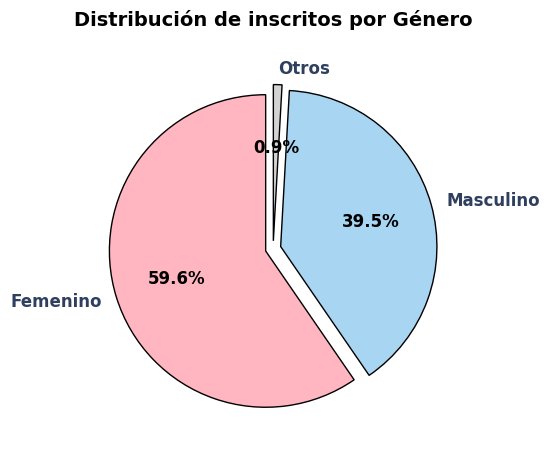

In [27]:
# 1. DISTRIBUCIÓN POR GÉNERO
dist_genero = df_alumnos.groupby('genero')['id'].nunique().reset_index().sort_values('id', ascending=False)
dist_genero.columns = ['Género', 'Inscritos']
dist_genero['% del total'] = (dist_genero['Inscritos'] / dist_genero['Inscritos'].sum() * 100).round(1)


# Crear figura con dos subplots (gráfico + tabla)
fig_genero = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = fig_genero.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

# --- SUBPLOT 1: Gráfico de Torta ---
ax_pie = fig_genero.add_subplot(gs[0])


# Mapeo de colores específicos por género
color_map = {
    'Masculino': '#A8D5F2',  # Azul pastel
    'Femenino': '#FFB6C1',   # Rosa pastel
    'Otros': '#D3D3D3'  # Gris
}

# Asignar colores según el género en el DataFrame
colores = [color_map.get(genero, '#CCCCCC') for genero in dist_genero['Género']]
explode = [0.05] * len(dist_genero)  # Crear lista con 0.05 para cada categoría

wedges, texts, autotexts = ax_pie.pie(
    dist_genero['Inscritos'],
    labels=dist_genero['Género'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
)

# Estilo de los porcentajes (blancos sobre el gráfico)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Estilo de las etiquetas
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2E3F5F')

ax_pie.set_title('Distribución de inscritos por Género', 
                 fontsize=14, weight='bold', pad=20, color="black")


plt.show()

biblioteca['Demografico'].append({
    'name': 'distribucion_por_genero',
    'fig': fig_genero,
    'df': dist_genero
})

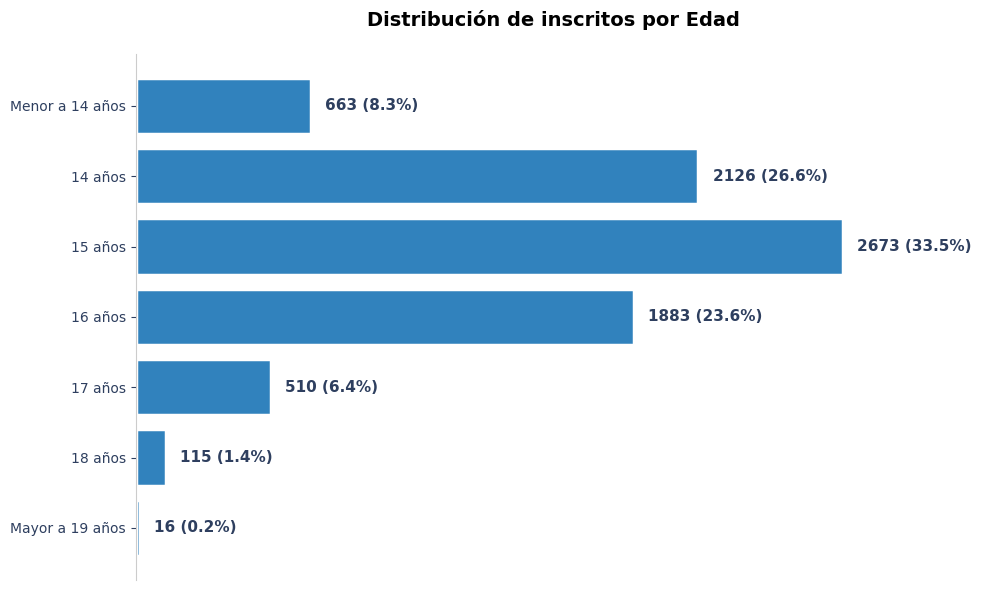

In [28]:
# 2. DISTRIBUCIÓN POR RANGO DE EDAD
def categorizar_edad(edad):
    if pd.isna(edad):
        return 'Sin información'
    elif edad <= 13:
        return 'Menor a 14 años'
    elif edad == 14:
        return '14 años'
    elif edad == 15:
        return '15 años'
    elif edad == 16:
        return '16 años'
    elif edad == 17:
        return '17 años'
    elif edad == 18:
        return '18 años'
    elif edad >= 19:
        return 'Mayor a 19 años'

df_alumnos['rango_edad'] = df_alumnos['edad'].apply(categorizar_edad)


dist_edad = df_alumnos.groupby('rango_edad')['id'].nunique().reset_index()
dist_edad.columns = ['Rango de Edad', 'Inscritos']
dist_edad['% del total'] = (dist_edad['Inscritos'] / dist_edad['Inscritos'].sum() * 100).round(1)

# Ordenar por rango
orden_edad = ['Menor a 14 años', '14 años', '15 años', '16 años', '17 años', '18 años', 'Mayor a 19 años', 'Sin información']
dist_edad['Rango de Edad'] = pd.Categorical(dist_edad['Rango de Edad'], categories=orden_edad, ordered=True)
dist_edad = dist_edad.sort_values('Rango de Edad')

# 1. Distribución por Edad
fig_edad = crear_grafico_distribucion(
    df_distribucion=dist_edad,
    col_categoria='Rango de Edad',
    col_cantidad='Inscritos',
    titulo_grafico='Distribución de inscritos por Edad',
    label_y=''
)

biblioteca['Demografico'].append({
    'name': 'distribucion_por_rango_etario',
    'fig': fig_edad,
    'df': dist_edad
})

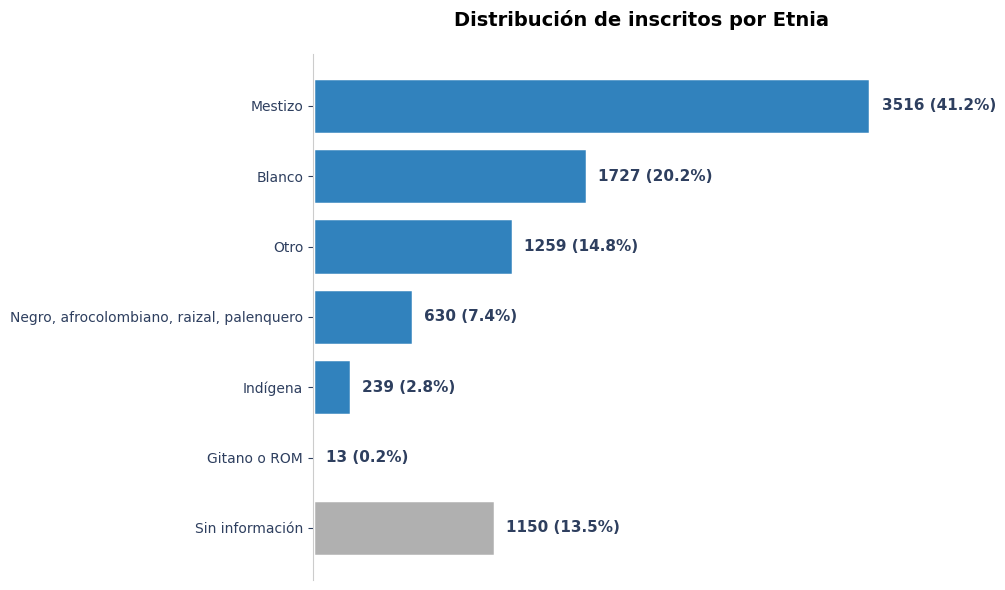

In [29]:
# 4. DISTRIBUCIÓN POR ETNIA/ASCENDENCIA
tiene_etnia = df_alumnos['etnia'].notnull().all()
if tiene_etnia:
    # Desagregar etnias concatenadas (separadas por |)
    def desagregar(df, desagregar_por='etnia', id_col='id', separardor=';'):
        """
        Desagrega cuando un estudiante tiene múltiples valores separados por ;
        """
        # Lista para almacenar los registros desagregados
        registros_desagregados = []
        
        for idx, row in df.iterrows():
            columna_valor = row[desagregar_por]
            
            # Si el valor es nulo o vacío
            if pd.isna(columna_valor) or str(columna_valor).strip() == '':
                registros_desagregados.append({
                    'id': row[id_col],
                    'valor_individual': 'Sin información'
                })
            else:
                # Separar por | y crear un registro por cada etnia
                etnias = str(columna_valor).split(separardor)
                for etnia in etnias:
                    etnia_limpia = etnia.strip()
                    if etnia_limpia:  # Solo si no está vacío
                        registros_desagregados.append({
                            'id': row[id_col],
                            'valor_individual': etnia_limpia
                        })
        
        return pd.DataFrame(registros_desagregados)

    # Desagregar las etnias
    df_etnias_desagregadas = desagregar(df_alumnos)

    # Calcular distribución
    dist_etnia = df_etnias_desagregadas.groupby('valor_individual')['id'].nunique().reset_index()

    # Quitar #. del inicio si existe
    dist_etnia['valor_individual'] = dist_etnia['valor_individual'].str.replace(r'^\d+\.\s*', '', regex=True)

    dist_etnia.columns = ['Etnia/Ascendencia', 'Identificadas']
    dist_etnia=dist_etnia.sort_values('Identificadas', ascending=False)

    # Calcular porcentaje sobre el total de estudiantes únicos
    total_estudiantes = df_alumnos['id'].nunique()
    dist_etnia['% del total'] = (dist_etnia['Identificadas'] / total_estudiantes * 100).round(1)

    # grafico
    fig_etnia = crear_grafico_distribucion(
        df_distribucion=dist_etnia,
        col_categoria='Etnia/Ascendencia',
        col_cantidad='Identificadas',
        titulo_grafico='Distribución de inscritos por Etnia',
        label_y='',
        colormap='#3182bd')

    biblioteca['Demografico'].append({
        'name': 'distribucion_por_etnia',
        'fig': fig_etnia,
        'df': dist_etnia
    })

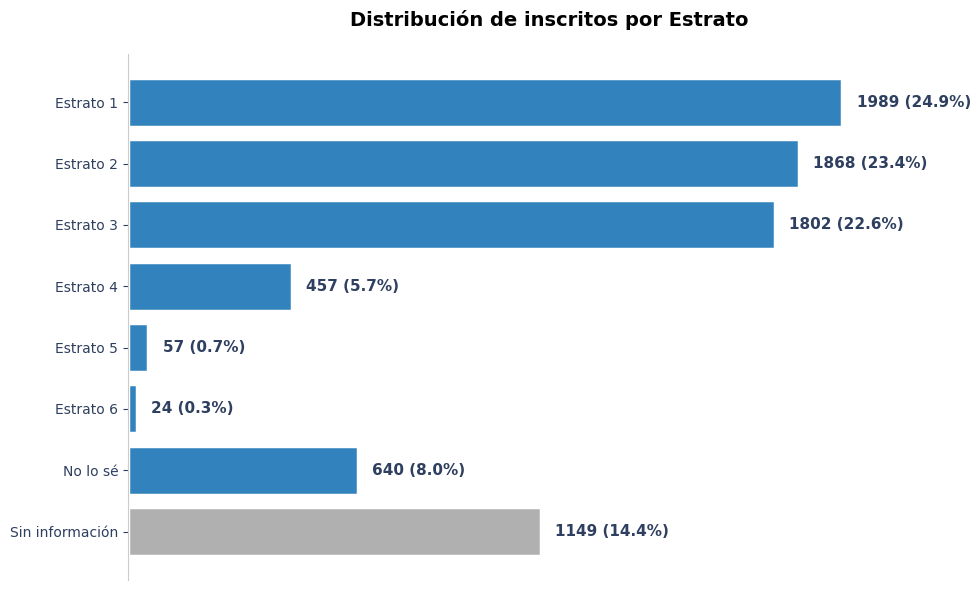

In [30]:
# 3. DISTRIBUCIÓN POR ESTRATO SOCIOECONÓMICO
dist_estrato = df_alumnos.groupby('estrato_socioeconomico')['id'].nunique().reset_index()
dist_estrato.columns = ['Estrato', 'Estudiantes']
dist_estrato['% del total'] = (dist_estrato['Estudiantes'] / dist_estrato['Estudiantes'].sum() * 100).round(1)
dist_estrato = dist_estrato.sort_values('Estrato')
# Quitar #. del inicio si existe
dist_estrato['Estrato'] = dist_estrato['Estrato'].str.replace(r'^\d+\.\s*', '', regex=True)

fig_estrato = crear_grafico_distribucion(
    df_distribucion=dist_estrato,
    col_categoria='Estrato',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de inscritos por Estrato',
    label_y='',
    colormap='#3182bd')

biblioteca['Demografico'].append({
    'name': 'Distribucion por estrato economico',
    'fig': fig_estrato,
    'df': dist_estrato
})

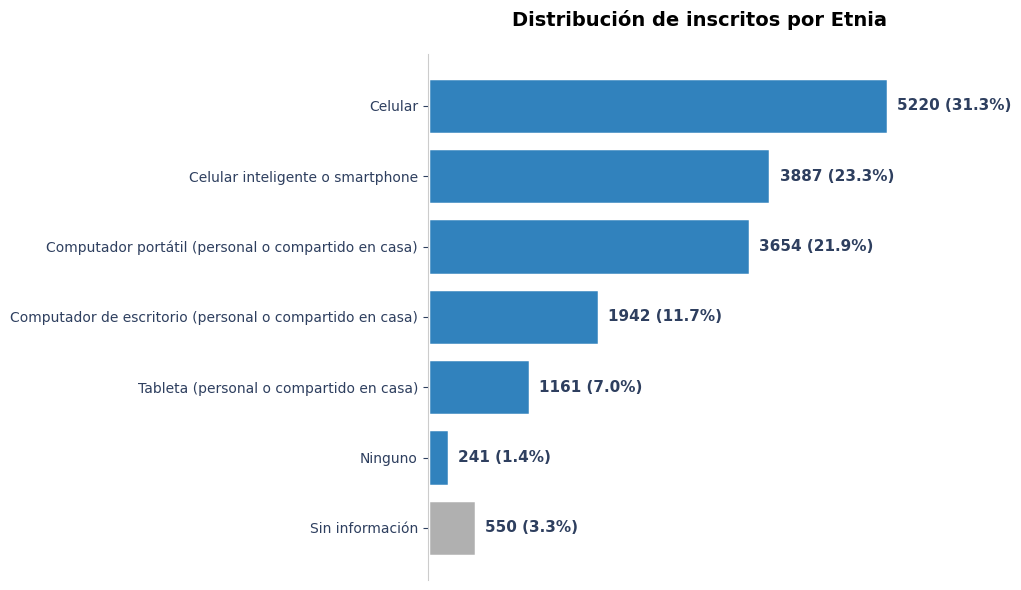

In [31]:
# Desagregar las etnias
df_dispositivos_personales_desagregadas = desagregar(df_alumnos, 'dispositivo_personal')

# Calcular distribución
dist_dispositivos_personales = df_dispositivos_personales_desagregadas.groupby('valor_individual')['id'].nunique().reset_index()

# Quitar #. del inicio si existe
dist_dispositivos_personales['valor_individual'] = dist_dispositivos_personales['valor_individual'].str.replace(r'^\d+\.\s*', '', regex=True)

dist_dispositivos_personales.columns = ['Dispositivo personal', 'Identificados']
dist_dispositivos_personales=dist_dispositivos_personales.sort_values('Identificados', ascending=False)

# Calcular porcentaje sobre el total de estudiantes únicos
total_estudiantes = df_alumnos['id'].nunique()
dist_dispositivos_personales['% del total'] = (dist_dispositivos_personales['Identificados'] / total_estudiantes * 100).round(1)

# grafico
fig_dispositivos_personales = crear_grafico_distribucion(
    df_distribucion=dist_dispositivos_personales,
    col_categoria='Dispositivo personal',
    col_cantidad='Identificados',
    titulo_grafico='Distribución de inscritos por Etnia',
    label_y='',
    colormap='#3182bd')

biblioteca['Demografico'].append({
    'name': 'distribucion_por_dispositivos_personales',
    'fig': fig_dispositivos_personales,
    'df': dist_dispositivos_personales
})

# Analisis de asistencia

## Funciones

In [32]:
def crear_grafico_cards(datos_cards, titulo_general="Dashboard de Métricas", 
                        filas=1, columnas=None, figsize=None):
    """
    Crea un gráfico con múltiples cards de información.
    
    Parámetros:
    -----------
    datos_cards : list of dict
        Lista de diccionarios con la información de cada card.
        Cada diccionario debe tener:
        - 'titulo': str - Título de la card
        - 'valor': float o str - Valor principal a mostrar
        - 'subtitulo': str (opcional) - Texto debajo del valor
        - 'sufijo': str (opcional) - Sufijo para el valor (ej: '%', 'hrs', etc.)
    
    titulo_general : str
        Título general del gráfico
    
    filas : int
        Número de filas para organizar las cards
    
    columnas : int (opcional)
        Número de columnas. Si no se especifica, se calcula automáticamente
    
    figsize : tuple (opcional)
        Tamaño de la figura (ancho, alto)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        La figura creada
    
    Ejemplo de uso:
    ---------------
    datos = [
        {'titulo': 'Asistencia General', 'valor': 85.5, 'sufijo': '%', 
         'subtitulo': 'Promedio mensual'},
        {'titulo': 'Horas Trabajadas', 'valor': 160, 'sufijo': ' hrs', 
         'subtitulo': 'Este mes'},
        {'titulo': 'Proyectos Activos', 'valor': 12, 
         'subtitulo': 'En desarrollo'}
    ]
    fig = crear_grafico_cards(datos)
    plt.show()
    """
    
    num_cards = len(datos_cards)
    
    # Calcular columnas automáticamente si no se especifica
    if columnas is None:
        columnas = min(3, num_cards)  # Máximo 3 columnas
        filas = (num_cards + columnas - 1) // columnas
    
    # Calcular figsize automáticamente si no se especifica
    if figsize is None:
        ancho = columnas * 5
        alto = filas * 3.5
        figsize = (ancho, alto)
    
    # Crear figura
    fig = plt.figure(figsize=figsize)
    fig.suptitle(titulo_general, fontsize=16, weight='bold', y=0.98, wrap=True)
    
    # Crear grid
    gs = gridspec.GridSpec(filas, columnas, figure=fig, 
                          hspace=0.4, wspace=0.3,
                          left=0.08, right=0.92, top=0.92, bottom=0.08)
    
    # Crear cada card
    for idx, card_data in enumerate(datos_cards):
        fila = idx // columnas
        col = idx % columnas
        
        ax = fig.add_subplot(gs[fila, col])
        ax.axis('off')
        
        # Extraer datos de la card
        titulo = card_data.get('titulo', 'Sin título')
        valor = card_data.get('valor', 0)
        subtitulo = card_data.get('subtitulo', '')
        sufijo = card_data.get('sufijo', '')
        
        # Crear tarjeta con bordes redondeados
        card = FancyBboxPatch(
            (0.05, 0.1), 0.9, 0.8,
            boxstyle="round,pad=0.05",
            facecolor='#E3F2FD',      # Azul muy claro de fondo
            edgecolor='#1565C0',       # Azul oscuro para borde
            linewidth=2.5,
            transform=ax.transAxes,
            zorder=1
        )
        ax.add_patch(card)
        
        # Título de la tarjeta con wrapping automático
        # Calcular ancho máximo en caracteres (aproximado)
        max_chars_por_linea = 25  # Ajustar según necesidad
        
        # Dividir el título en líneas sin cortar palabras
        palabras = titulo.split()
        lineas = []
        linea_actual = []
        
        for palabra in palabras:
            linea_test = ' '.join(linea_actual + [palabra])
            if len(linea_test) <= max_chars_por_linea:
                linea_actual.append(palabra)
            else:
                if linea_actual:
                    lineas.append(' '.join(linea_actual))
                linea_actual = [palabra]
        
        if linea_actual:
            lineas.append(' '.join(linea_actual))
        
        titulo_formateado = '\n'.join(lineas)
        
        # Ajustar posición vertical según número de líneas
        if len(lineas) == 1:
            y_titulo = 0.75
        elif len(lineas) == 2:
            y_titulo = 0.78
        else:
            y_titulo = 0.80
        
        ax.text(
            0.5, y_titulo,
            titulo_formateado,
            ha='center',
            va='center',
            fontsize=12,
            weight='bold',
            color='#0D47A1',          # Azul oscuro
            transform=ax.transAxes,
            multialignment='center'
        )
        
        # Valor principal (NEGRO)
        valor_texto = f'{valor}{sufijo}' if isinstance(valor, (int, float)) else str(valor)
        
        # Ajustar tamaño de fuente según longitud del texto
        if len(valor_texto) > 8:
            fontsize_valor = 32
        elif len(valor_texto) > 6:
            fontsize_valor = 38
        else:
            fontsize_valor = 44
        
        ax.text(
            0.5, 0.45,
            valor_texto,
            ha='center',
            va='center',
            fontsize=fontsize_valor,
            weight='bold',
            color='black',            # COLOR NEGRO para el porcentaje/valor
            transform=ax.transAxes
        )
        
        # Subtítulo (si existe)
        if subtitulo:
            ax.text(
                0.5, 0.2,
                subtitulo,
                ha='center',
                va='center',
                fontsize=9,
                color='#424242',      # Gris oscuro
                transform=ax.transAxes,
                style='italic'
            )
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    return fig

In [33]:
def asistencia_por(df: dataframes, agrupacion: str):

    # Calcular % de asistencias por proyecto
    asistencias_por = (
        df.groupby(agrupacion)
        .apply(lambda grupo: pd.Series({
            'Total_registros': grupo['attendance_id'].nunique(),
            'Asistencias': grupo[grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique(),
            'Faltas': grupo[~grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique()
        }), include_groups=False)
        .reset_index()
    )

    asistencias_por['% Asistencia'] = round(
        (asistencias_por['Asistencias'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por['% Falta'] = round(
        (asistencias_por['Faltas'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por.drop(columns=['Faltas', 'Asistencias', 'Total_registros'], inplace=True)

    return asistencias_por

In [34]:
def grafico_columnas_asistencia(df: dataframes, titulo_grafico: str,
                                xlabel: str = 'Mes', ylabel: str = '% Asistencia'):
    """
    Crea un gráfico de columnas con la asistencia mensual en formato profesional.
   
    Parámetros:
    -----------
    df : dataframes
        DataFrame con los datos de asistencia
    guardar : str
        Clave para guardar en la biblioteca
    titulo_grafico : str
        Título principal del gráfico
    xlabel : str
        Etiqueta del eje X (por defecto 'Mes')
    ylabel : str
        Etiqueta del eje Y (por defecto '% Asistencia')
   
    Returns:
    --------
    fig : matplotlib.figure.Figure
    """
    global asistencia_por_fecha
    
    if xlabel == 'Mes': 
        agrupacion = 'mes'
    else:
        agrupacion = 'semana'

    # Obtener datos de asistencia por mes
    asistencia_por_fecha = asistencia_por(df, agrupacion)

    # Asegurar orden cronológico
    sort_column = "start_month" if agrupacion == "mes" else "start_week" 

    sort_mapping = df[[agrupacion, sort_column]].drop_duplicates().set_index(agrupacion)[sort_column]
    asistencia_por_fecha['_sort'] = asistencia_por_fecha[agrupacion].map(sort_mapping)
    asistencia_por_fecha = asistencia_por_fecha.sort_values('_sort').drop('_sort', axis=1)

   
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
   
    # Color sólido profesional
    color_barras = '#3182bd'
   
    # Crear gráfico de barras
    bars = ax.bar(
        asistencia_por_fecha[agrupacion],
        asistencia_por_fecha['% Asistencia'],
        color=color_barras,
        edgecolor='#1565C0',
        linewidth=1.5,
        alpha=0.9,
        width=0.7
    )
   
    # Agregar etiquetas sobre las barras con valores
    for bar, porcentaje in zip(bars, asistencia_por_fecha['% Asistencia']):
        altura = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 1.2,
            f'{porcentaje:.1f}%',
            ha='center',
            va='bottom',
            fontsize=11,
            weight='bold',
            color='#0D47A1'
        )
   
    # Título principal
    ax.set_title(
        titulo_grafico,
        fontsize=16,
        weight='bold',
        pad=20,
        color='black'
    )
   
    # Etiquetas de ejes
    ax.set_xlabel(xlabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
   
    # Grilla sutil para facilitar la lectura
    ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#BBDEFB')
    ax.set_axisbelow(True)
   
    # Estilo de los bordes (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#90CAF9')
    ax.spines['bottom'].set_color('#90CAF9')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
   
    # Estilo de los ticks
    ax.tick_params(
        axis='x',
        colors='#424242',
        labelsize=10,
        rotation=45,
        length=5,
        width=1.5
    )
    ax.tick_params(
        axis='y',
        colors='#424242',
        labelsize=10,
        length=5,
        width=1.5
    )
    ax.set_yticks([])
   
    # Ajustar límites del eje Y para mejor visualización
    ax.set_ylim(0, 108)
   
    # Ajustar layout para que no se corten las etiquetas
    plt.tight_layout()
   
    return fig


## Analisis

In [35]:
promedio_alumnos_asistentes_por_salon=int(
    df_asistencias[df_asistencias['attendance_status']=='A']
    .groupby('room_id')['student_id']
    .nunique()
    .mean()
    )

In [36]:
# Normalizacion
df_asistencias['start_date'] = pd.to_datetime(df_asistencias['start_date'])
df_asistencias['mes'] = df_asistencias['start_date'].dt.to_period('M').astype(str)

df_asistencias['start_month'] = df_asistencias['start_date'].dt.to_period('M').dt.start_time
df_asistencias['start_week'] = df_asistencias['start_date'].dt.to_period('W').dt.start_time

df_asistencias['semana'] = (
    df_asistencias['start_date'].dt.to_period('W').dt.start_time.dt.strftime('%d/%m') + 
    '-' + 
    (df_asistencias['start_date'].dt.to_period('W').dt.start_time + pd.Timedelta(days=6)).dt.strftime('%d/%m')
)

# condicional
# Tiene mas de 1 mes de datos?
tiene_multiples_meses = df_asistencias['mes'].nunique() > 1

# Variables
df_asistencia_profe = df_asistencias[df_asistencias['content_definition'] == 'Profesor CTC'].copy()
df_asistencia_alumno = df_asistencias[df_asistencias['content_definition'] == 'Alumno'].copy()

In [37]:
if tiene_instituciones:
    asistencia_institucion = asistencia_por(
        df_asistencia_alumno, 'institution').sort_values('% Asistencia', ascending=False).rename(columns={'institution':'Institución Educativa'})
    
    # Guardar en biblioteca
    biblioteca['Asistencias'].append({
        'name': 'Asistencia por Institución Educativa',
        'df': pd.DataFrame(asistencia_institucion)
    })


if tiene_grados:
    asistencia_grado = asistencia_por(
        df_asistencia_alumno, 'grade').sort_values('% Asistencia', ascending=False).rename(columns={'grade':'Grado'})
    
    asistencia_grado['Grado']=asistencia_grado['Grado'].astype(int).astype(str)
    # Guardar en biblioteca
    biblioteca['Asistencias'].append({
        'name': 'Asistencia por grados',
        'df': pd.DataFrame(asistencia_grado)
    })

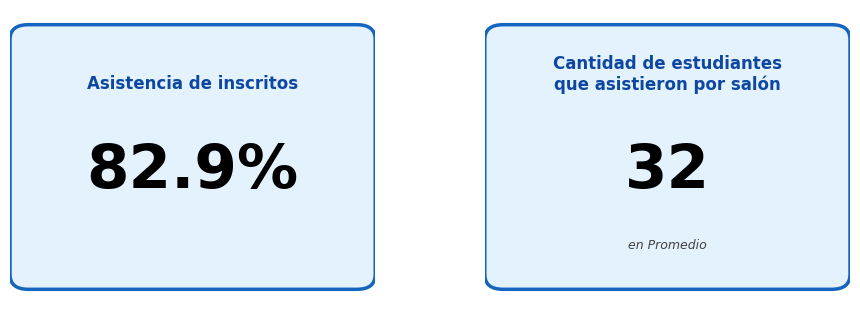

In [38]:
datos_asistencia = [
    {
        'titulo': 'Asistencia de inscritos',
        'valor': asistencia_por(df_asistencia_alumno, 'name')['% Asistencia'][0],
        'sufijo': '%'
    },
    {
        'titulo': 'Cantidad de estudiantes que asistieron por salón',
        'valor': promedio_alumnos_asistentes_por_salon,
        'subtitulo': 'en Promedio'
    }
    ]

fig_tarjetas_asistencias= crear_grafico_cards(datos_asistencia, titulo_general="")

# Guardar en biblioteca
biblioteca['Asistencias'].append({
    'name': 'Tarjetas de asistencia',
    'fig': fig_tarjetas_asistencias,
    'df': pd.DataFrame(datos_asistencia)
})


2025-12-11 15:06:57,481 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 15:06:57,484 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


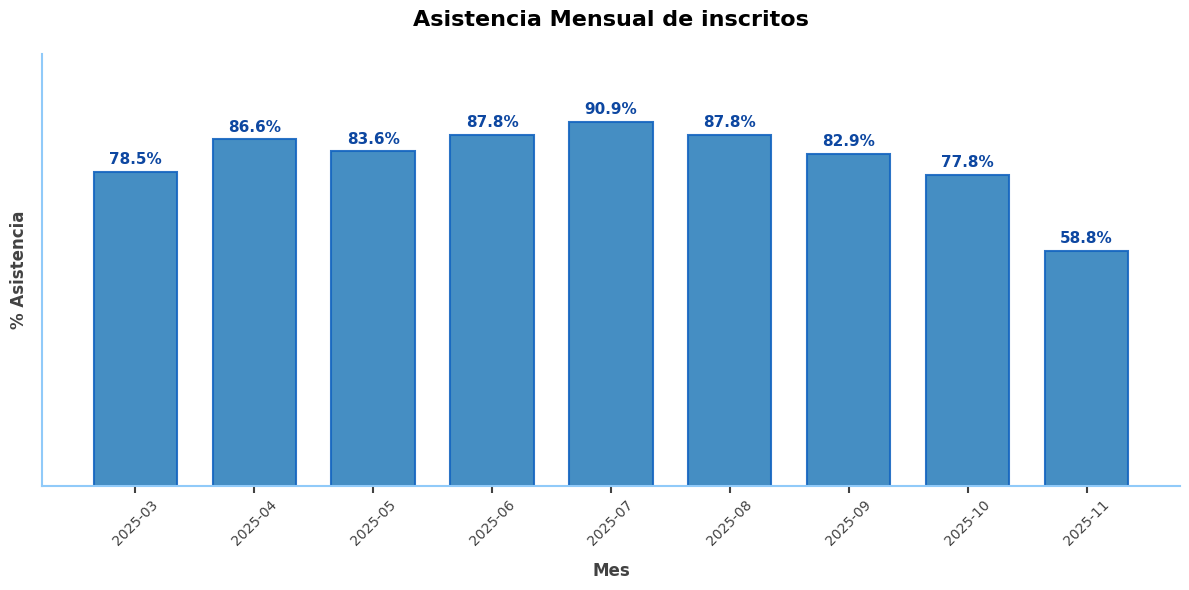

In [39]:
fig_asistencia_alumno= grafico_columnas_asistencia(
    df=df_asistencia_alumno,
    titulo_grafico='Asistencia Mensual de inscritos' if tiene_multiples_meses else 'Asistencia Semanal de inscritos',
    xlabel='Mes' if tiene_multiples_meses else 'Semana'
)

# Guardar en biblioteca
biblioteca['Asistencias'].append({
    'name': 'Asistencia Mensual de inscritos' if tiene_multiples_meses else 'Asistencia Semanal de inscritos',
    'df': pd.DataFrame(asistencia_por_fecha)
})

In [40]:
# fig_asistencia_profe= grafico_columnas_asistencia(
#     df=df_asistencia_profe,
#     titulo_grafico='Asistencia Mensual de Profesores'
# )

# # Guardar en biblioteca
# biblioteca['Asistencias'].append({
#     'name': 'Asistencia de profes por mes',
#     'df': pd.DataFrame(asistencia_por(df_asistencia_profe, 'mes').sort_values('mes'))
# })

# Cancelaciones

In [41]:
df_cancelaciones['fecha'] = pd.to_datetime(df_cancelaciones['fecha']).dt.date
df_cancelaciones['mes'] = pd.to_datetime(df_cancelaciones['fecha']).dt.to_period('M').astype(str)

In [42]:
resumen_cancelaciones_por_mes=df_cancelaciones.groupby('mes').agg(
    sesiones_programadas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'fecha'] <= today]['sesionid'].nunique()),
    sesiones_canceladas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'state'] == 'false']['sesionid'].nunique())
).reset_index()

resumen_cancelaciones_por_mes['% Cancelación']=round(
    (resumen_cancelaciones_por_mes['sesiones_canceladas'] / resumen_cancelaciones_por_mes['sesiones_programadas'])*100,1)

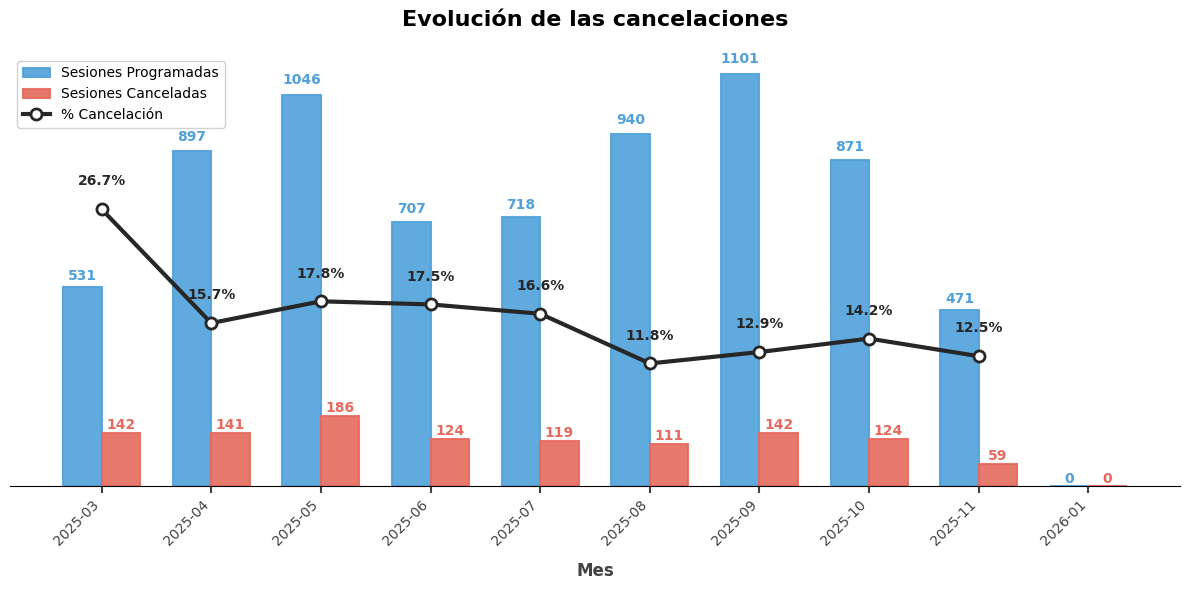

In [43]:
# Crear figura con dos ejes Y
fig_cancelaciones_mes, ax1 = plt.subplots(figsize=(12, 6))
fig_cancelaciones_mes.patch.set_facecolor('white')

# Colores profesionales
color_programadas = "#50a1db"
color_canceladas = "#e66a5d"
color_linea = "#272727"

# Ancho de las barras
ancho = 0.35
x = range(len(resumen_cancelaciones_por_mes))

# Crear barras para sesiones programadas y canceladas
bars1 = ax1.bar(
    [i - ancho/2 for i in x],
    resumen_cancelaciones_por_mes['sesiones_programadas'],
    width=ancho,
    color=color_programadas,
    edgecolor='#50a1db',
    linewidth=1.5,
    alpha=0.9,
    label='Sesiones Programadas'
)

bars2 = ax1.bar(
    [i + ancho/2 for i in x],
    resumen_cancelaciones_por_mes['sesiones_canceladas'],
    width=ancho,
    color=color_canceladas,
    edgecolor='#e66a5d',
    linewidth=1.5,
    alpha=0.9,
    label='Sesiones Canceladas'
)

# Agregar etiquetas sobre las barras de sesiones programadas
for bar, valor in zip(bars1, resumen_cancelaciones_por_mes['sesiones_programadas']):
    altura = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        altura + (altura * 0.02),
        f'{int(valor)}',
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=color_programadas
    )

# Agregar etiquetas sobre las barras de sesiones canceladas
for bar, valor in zip(bars2, resumen_cancelaciones_por_mes['sesiones_canceladas']):
    altura = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        altura + (altura * 0.02),
        f'{int(valor)}',
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=color_canceladas
    )

# Configurar primer eje Y (para las barras)
ax1.set_xlabel('Mes', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax1.set_ylabel('', fontsize=12, weight='bold', color='#424242', labelpad=10)

ax1.tick_params(axis='y', labelcolor='#424242', labelsize=10, length=5, width=1.5)
ax1.set_xticks(x)
ax1.set_xticklabels(resumen_cancelaciones_por_mes['mes'], rotation=45, ha='right')
ax1.tick_params(axis='x', colors='#424242', labelsize=10, length=5, width=1.5)

# Ocultar los valores del eje Y izquierdo
ax1.set_yticks([])

# Crear segundo eje Y para el porcentaje (línea)
ax2 = ax1.twinx()


# Crear línea para el porcentaje de cancelación
line = ax2.plot(
    x,
    resumen_cancelaciones_por_mes['% Cancelación'],
    color=color_linea,
    linewidth=3,
    marker='o',
    markersize=8,
    label='% Cancelación',
    linestyle='-',
    markerfacecolor='white',
    markeredgewidth=2,
    markeredgecolor=color_linea
)

# Agregar etiquetas sobre los puntos de la línea
for i, porcentaje in enumerate(resumen_cancelaciones_por_mes['% Cancelación']):
    ax2.text(
        i,
        porcentaje + 2,
        f'{porcentaje:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold',
        color=color_linea
    )

# Configurar segundo eje Y
ax2.set_ylabel('', fontsize=12, weight='bold', color=color_linea, labelpad=10)
ax2.tick_params(axis='y', labelcolor=color_linea, labelsize=10, length=5, width=1.5)
ax2.set_ylim(0, max(resumen_cancelaciones_por_mes['% Cancelación']) + 15)

# Título principal
ax1.set_title(
    'Evolución de las cancelaciones',
    fontsize=16,
    weight='bold',
    pad=20,
    color='black'
)

# Ocultar los valores del eje Y derecho
ax2.set_yticks([])

# Grilla sutil
ax1.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#BBDEFB')
ax1.set_axisbelow(True)

# Estilo de los bordes
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)  # ← Cambiar a False
ax1.spines['bottom'].set_color('#90CAF9')
ax1.spines['bottom'].set_linewidth(0.5)
ax1.spines['right'].set_visible(False)  # ← Agregar esta línea

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)  # ← Cambiar a False
ax2.spines['left'].set_visible(False)   # ← Agregar esta línea


# Combinar leyendas de ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9, fontsize=10)

# Ajustar layout
plt.tight_layout()

# Guardar en biblioteca
biblioteca['Cancelaciones'].append({
    'name': 'Cancelaciones por mes',
    'fig': fig_cancelaciones_mes,
    'df': pd.DataFrame(resumen_cancelaciones_por_mes)
})

In [44]:
## --- TARJETAS GENERALES DE CANCELACIONES --- ## 

sesiones_canceladas=df_cancelaciones[df_cancelaciones['state']=='false']['sesionid'].nunique()
sesiones_programadas=df_cancelaciones[df_cancelaciones['fecha']<=today]['sesionid'].nunique()
#sesiones_programadas_hasta_hoy=df_cancelaciones[df_cancelaciones['fecha']<=today]['sesionid'].nunique()
sesiones_dictadas=df_cancelaciones[
    (df_cancelaciones['state'] == 'true') & (df_cancelaciones['fecha'] <= today)
]['sesionid'].nunique()

porcentaje_cancelacion=round((sesiones_canceladas / sesiones_programadas)*100,2)
porcentaje_dictado=round(sesiones_dictadas/sesiones_programadas*100, 2)

## -- RESUMEN POR PROYECTO DE CANCELACIONES -- ##
resumen_cancelaciones_por_proyecto=df_cancelaciones.groupby('projectsid').agg(
    sesiones_programadas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'fecha'] <= today]['sesionid'].nunique()),
    sesiones_canceladas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'state'] == 'false']['sesionid'].nunique())
)

resumen_cancelaciones_por_proyecto['% Cancelación']=round(
    resumen_cancelaciones_por_proyecto['sesiones_canceladas'] 
    / resumen_cancelaciones_por_proyecto['sesiones_programadas'] * 100,2)

resumen_cancelaciones_por_proyecto['% Dictado']=round(100-resumen_cancelaciones_por_proyecto['% Cancelación'],2)

resumen_cancelaciones_por_proyecto.rename(columns={'sesiones_programadas':'Sesiones programadas', 'sesiones_canceladas':'Sesiones canceladas'}, inplace=True)
## -- MOTIVOS DE CANCELACIONES -- ## 

resumen_motivos_cancalaciones=(
    df_cancelaciones[df_cancelaciones['state']=='false']
    .groupby('motivo')
    .agg(
        sesiones_canceladas=('sesionid', 'nunique')
    )
    ).sort_values('sesiones_canceladas', ascending=False
    ).reset_index()

resumen_motivos_cancalaciones['% Cancelación']=round(
    resumen_motivos_cancalaciones['sesiones_canceladas'] 
    / sesiones_canceladas * 100,1)
    
resumen_motivos_cancalaciones.rename(columns={'motivo':'Motivo', 'sesiones_canceladas': 'Sesiones canceladas'}, inplace=True)

## -- CANCELACIONES POR IE -- ## 

if tiene_instituciones:
    resumen_cancelaciones_IE = (
        df_cancelaciones
        .groupby('institucion')
        .agg(
            sesiones_programadas=(
                'sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'fecha'] <= today]['sesionid'].nunique()
            ),
            sesiones_canceladas=(
                'sesionid',
                lambda s: s[df_cancelaciones.loc[s.index, 'state'] == 'false'].nunique()
            ),
            sesiones_dictadas=(
                'sesionid',
                lambda s: s[
                    (df_cancelaciones.loc[s.index, 'state'] == 'true') &
                    (df_cancelaciones.loc[s.index, 'fecha'] <= today)
                ].nunique()
            ),
            motivo_principal=(
                'motivo',
                lambda m: m[df_cancelaciones.loc[m.index, 'state'] == 'false'].mode()[0] 
                if len(m[df_cancelaciones.loc[m.index, 'state'] == 'false']) > 0 and not m[df_cancelaciones.loc[m.index, 'state'] == 'false'].mode().empty
                else 'Sin cancelaciones'
            )
        )
        .reset_index()
    )
        
    resumen_cancelaciones_IE['% Cancelación'] = round(
        resumen_cancelaciones_IE['sesiones_canceladas'] 
        / resumen_cancelaciones_IE['sesiones_programadas'] * 100, 1)
    
    resumen_cancelaciones_IE['% Dictadas'] = round(
        resumen_cancelaciones_IE['sesiones_dictadas'] 
        / resumen_cancelaciones_IE['sesiones_programadas'] * 100, 1)
    
    resumen_cancelaciones_IE.rename(columns={
        'institucion': 'Institución', 
        'sesiones_canceladas': 'Sesiones canceladas', 
        'sesiones_dictadas': 'Sesiones dictadas', 
        'sesiones_programadas': 'Sesiones programadas',
        'motivo_principal': 'Motivo principal'
    }, inplace=True)

    resumen_cancelaciones_IE.sort_values('% Cancelación', ascending=False, inplace=True)

    resumen_cancelaciones_IE = resumen_cancelaciones_IE[['Institución', 'Sesiones programadas', 'Sesiones canceladas', 'Sesiones dictadas', '% Cancelación', '% Dictadas', 'Motivo principal']]

    biblioteca['Cancelaciones'].append({
        'name': 'Cancelaciones por institución educativa',
        'df': resumen_cancelaciones_IE
    })

## -- CANCELACIONES POR GRADO -- ##
if tiene_grados:
    resumen_cancelaciones_grados = (
        df_cancelaciones
        .groupby('grado')
        .agg(
            sesiones_programadas=(
                'sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'fecha'] <= today]['sesionid'].nunique()
            ),
            sesiones_canceladas=(
                'sesionid',
                lambda s: s[df_cancelaciones.loc[s.index, 'state'] == 'false'].nunique()
            ),
            sesiones_dictadas=(
                'sesionid',
                lambda s: s[
                    (df_cancelaciones.loc[s.index, 'state'] == 'true') &
                    (df_cancelaciones.loc[s.index, 'fecha'] <= today)
                ].nunique()
            )
        )
        .reset_index()
    )
        
    resumen_cancelaciones_grados['% Cancelación']=round(
        resumen_cancelaciones_grados['sesiones_canceladas'] 
        / resumen_cancelaciones_grados['sesiones_programadas'] * 100,1)
    
    resumen_cancelaciones_grados['% Dictadas']=round(
        resumen_cancelaciones_grados['sesiones_dictadas'] 
        / resumen_cancelaciones_grados['sesiones_programadas'] * 100,1)
        
    resumen_cancelaciones_grados.rename(columns={'grado':'Grado', 'sesiones_canceladas': 'Sesiones canceladas','sesiones_dictadas':'Sesiones dictadas', 'sesiones_programadas': 'Sesiones programadas'}, inplace=True)
    
    resumen_cancelaciones_grados.sort_values('% Cancelación', ascending=False, inplace=True)

    biblioteca['Cancelaciones'].append({
    'name': 'Cancelaciones por grados',
    'df': resumen_cancelaciones_grados
    })

In [45]:
datos_cancelaciones = [
    {
        'titulo': 'Sesiones programadas',
        'valor': sesiones_programadas,
    },
    {
        'titulo': 'Sesiones dictadas',
        'valor': sesiones_dictadas,
    },
    {
        'titulo': 'Sesiones canceladas',
        'valor': sesiones_canceladas
    },
    {
        'titulo': '% Sesiones dictadas',
        'valor': porcentaje_dictado,
        'sufijo': '%'
    },
    {
        'titulo': '% Sesiones canceladas',
        'valor': porcentaje_cancelacion,
        'sufijo': '%'
    }
]

# fig_tarjetas_cancelaciones= crear_grafico_cards(datos_cancelaciones, titulo_general="", filas=2, columnas=3)
# plt.show()

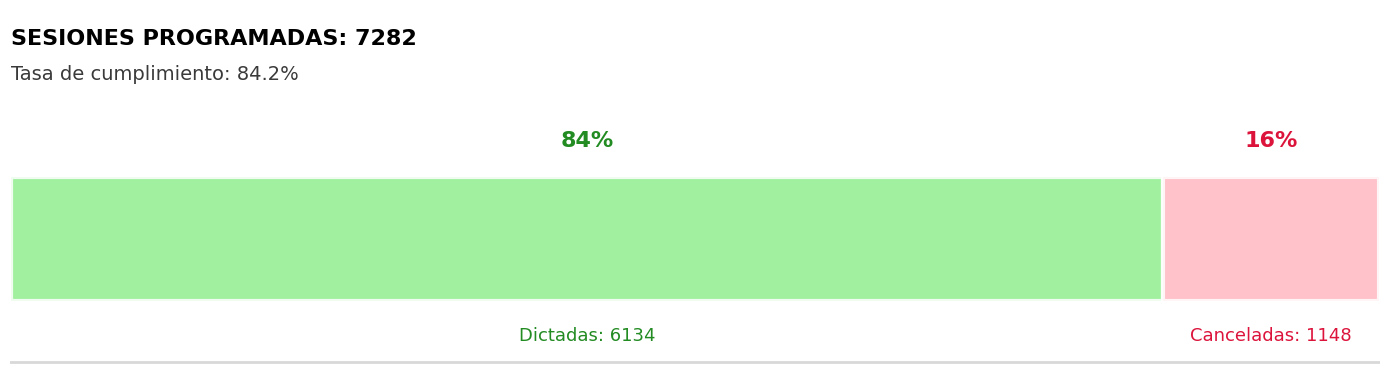

In [46]:
# Crear gráfico de barras apiladas horizontal - Estilo minimalista con colores pasteles
fig_barra_cancelaciones, ax = plt.subplots(figsize=(14, 4), facecolor='white')

# Fondo sutil
ax.set_facecolor('#F5F5F5')

# Colores pasteles elegantes (tus colores originales)
color_dictadas = '#90EE90'  # Verde claro
color_canceladas = '#FFB6C1'  # Rosa claro

# Crear barras apiladas horizontales con mejor definición
ax.barh(0, sesiones_dictadas, color=color_dictadas, height=0.7,
        alpha=0.85, edgecolor='white', linewidth=3)
ax.barh(0, sesiones_canceladas, left=sesiones_dictadas, 
        color=color_canceladas, height=0.7, alpha=0.85,
        edgecolor='white', linewidth=3)

# Indicadores de porcentaje arriba de la barra
y_pos = 0.5
if sesiones_dictadas > 0:
    # Porcentaje grande arriba
    ax.text(sesiones_dictadas/2, y_pos, 
            f'{porcentaje_dictado:.0f}%', 
            ha='center', va='bottom', fontsize=16, fontweight='bold', 
            color='#228B22')  # Verde más oscuro para contraste
    # Detalle abajo
    ax.text(sesiones_dictadas/2, -0.5, 
            f'Dictadas: {sesiones_dictadas}', 
            ha='center', va='top', fontsize=13, color='#228B22')

if sesiones_canceladas > 0:
    # Porcentaje grande arriba
    ax.text(sesiones_dictadas + sesiones_canceladas/2, y_pos, 
            f'{porcentaje_cancelacion:.0f}%', 
            ha='center', va='bottom', fontsize=16, fontweight='bold', 
            color='#DC143C')  # Rojo más oscuro para contraste
    # Detalle abajo
    ax.text(sesiones_dictadas + sesiones_canceladas/2, -0.5, 
            f'Canceladas: {sesiones_canceladas}', 
            ha='center', va='top', fontsize=13, color='#DC143C')

# Línea de progreso total sutil
ax.axhline(y=-0.7, xmin=0, xmax=1, color='gray', linewidth=2, alpha=0.3)

# Título con formato mejorado
titulo = f'SESIONES PROGRAMADAS: {sesiones_programadas}'
subtitulo = f'Tasa de cumplimiento: {porcentaje_dictado:.1f}%'

ax.text(0, 1.1, titulo, fontsize=16, fontweight='bold', 
        transform=ax.transData)
ax.text(0, 0.9, subtitulo, fontsize=14, color="#3B3A3A", 
        transform=ax.transData)

# Configuración limpia
ax.set_xlim(-5, sesiones_programadas + 5)
ax.set_ylim(-0.8, 1.3)
ax.axis('off')

plt.tight_layout()
plt.show()

# Guardar en biblioteca
biblioteca['Cancelaciones'].append({
    'name': 'Tarjetas de cancelaciones',
    'fig': fig_barra_cancelaciones,
    'df': pd.DataFrame(datos_cancelaciones)
})

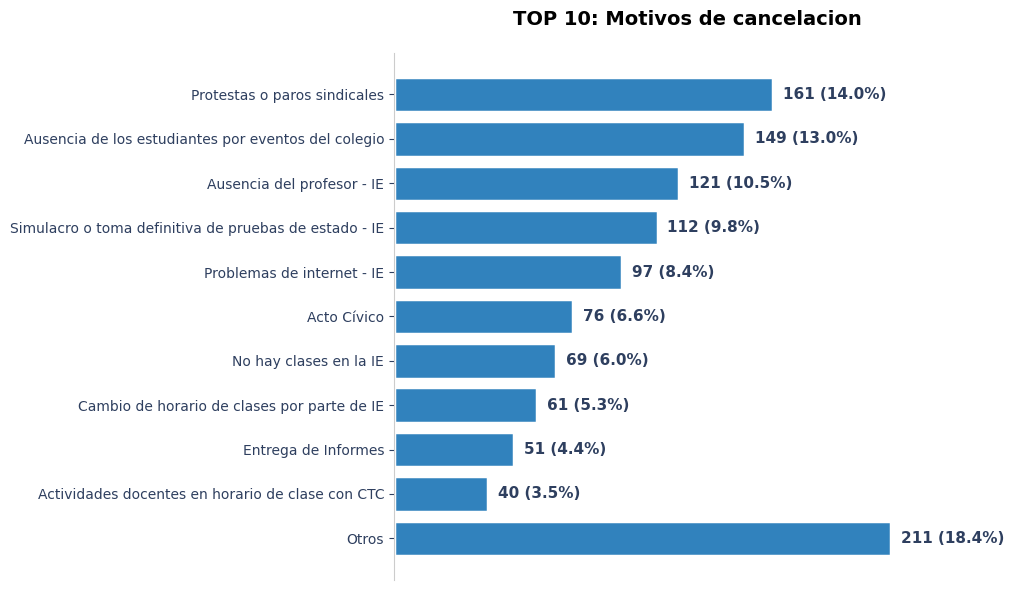

In [47]:
top_10_motivos_cancelacion=crear_top_n_con_otros(
    df=resumen_motivos_cancalaciones,
    columna_categoria='Motivo',
    columna_valor='Sesiones canceladas',
    n=10
)

cantidad_de_motivos=resumen_motivos_cancalaciones['Motivo'].nunique()

fig_top_10_cancelaciones = crear_grafico_distribucion(
    df_distribucion=top_10_motivos_cancelacion,
    col_categoria='Motivo',
    col_cantidad='Sesiones canceladas',
    titulo_grafico=f'TOP 10: Motivos de cancelacion' if cantidad_de_motivos > 10 else 'Motivos de cancelacion',
    label_y='',
    colormap= '#3182bd'
)

# Guardar en biblioteca
biblioteca['Cancelaciones'].append({
    'name': 'Top 10 motivos de cancelación',
    'fig': fig_top_10_cancelaciones,
    'df': top_10_motivos_cancelacion
})

biblioteca['Cancelaciones'].append({
    'name': 'Resumen cancelaciones por proyecto',
    'df': resumen_cancelaciones_por_proyecto
})

biblioteca['Cancelaciones'].append({
    'name': 'Motivos de cancelación',
    'df': resumen_motivos_cancalaciones
})

# Cuestionarios

In [48]:
# Función para clusterizar notas en rangos de 5 en 5
def clusterizar_notas(nota):
    """
    Clusteriza las notas en rangos de 5 en 5 puntos.
    
    Parámetros:
    -----------
    nota : float
        La nota a clusterizar
    
    Returns:
    --------
    str : Rango de la nota (ej: "0-4", "5-9", etc.)
    """
    if pd.isna(nota):
        return 'Sin nota'
    
    # Caso especial para el rango 95-100
    if nota >= 95:
        return '95-100'
    
    # Calcular el límite inferior del rango
    limite_inferior = int(nota // 5) * 5
    limite_superior = limite_inferior + 4  
    
    return f"{limite_inferior}-{limite_superior}"

# Aplicar la función al DataFrame
df_calificaciones['cluster_nota'] = df_calificaciones['nota_final_ponderada'].apply(clusterizar_notas)

In [49]:
alumnos_aprobados=df_calificaciones[df_calificaciones['nota_final_ponderada']>=60]['student_id'].nunique()
alumnos_desaprobados=df_calificaciones[df_calificaciones['nota_final_ponderada']<60]['student_id'].nunique()
total_evaluados=df_calificaciones[~df_calificaciones['nota_final_ponderada'].isnull()]['student_id'].nunique()
porcentaje_aprobacion=round((alumnos_aprobados / total_evaluados)*100,1)
porcentaje_desaprobacion=round((alumnos_desaprobados / total_evaluados)*100,1)
nota_promedio=df_calificaciones['nota_final_ponderada'].mean().astype(int)

alumnos_activos=df_alumnos['id'].nunique()
porcentaje_evaluados=round((total_evaluados / alumnos_activos)*100,1)

datos_cuestionarios = [
    {
        'titulo': 'Evaluados',
        'valor': total_evaluados
    },
    {
        'titulo': 'Aprobados',
        'valor': alumnos_aprobados,
        'sufijo': '',
    },
    {
        'titulo': 'Nota promedio',
        'valor': nota_promedio,
        'sufijo': '',
    },
    {
        'titulo': '% Evaluados',
        'valor': porcentaje_evaluados,
        'sufijo': '%',
        'subtitulo': 'sobre el total de inscritos activos'
    },
    {
        'titulo': '% Aprobación',
        'valor': porcentaje_aprobacion,
        'sufijo': '%'
    },
    {
        'titulo': '% Desaprobación',
        'valor': porcentaje_desaprobacion,
        'sufijo': '%'
    }
]

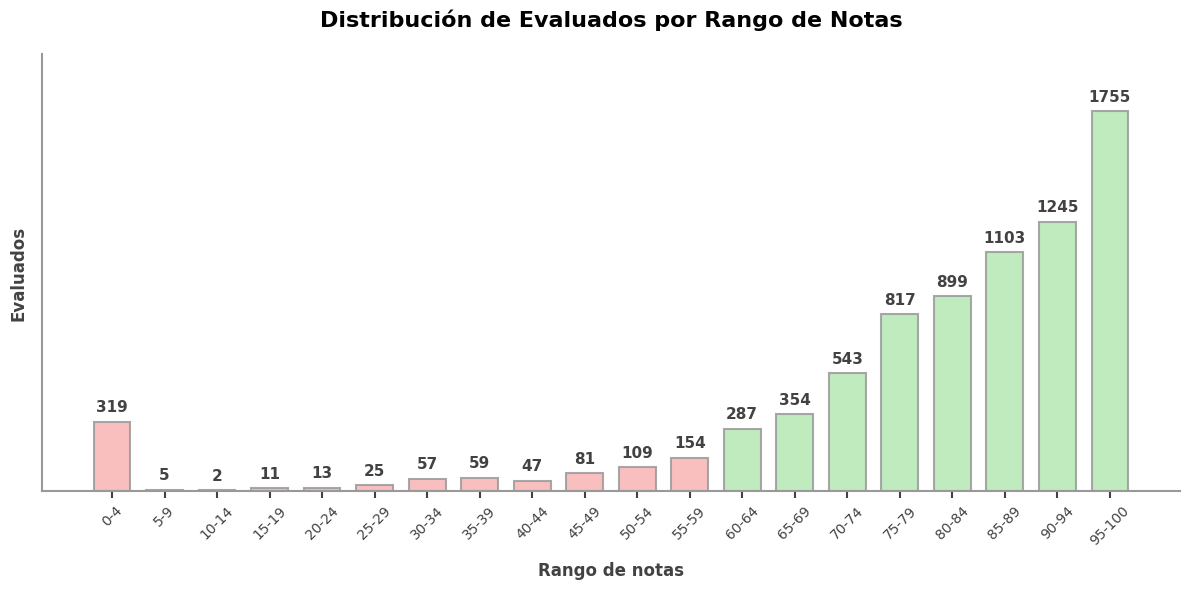

In [50]:
dist_notas = df_calificaciones.groupby('cluster_nota')['student_id'].nunique().reset_index()
dist_notas.columns = ['Cluster', 'evaluados']

# Ordenar los clusters correctamente
orden_clusters = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', 
                  '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', 
                  '80-84', '85-89', '90-94', '95-100']

# Filtrar solo los que existen y ordenar
dist_notas['Cluster'] = pd.Categorical(dist_notas['Cluster'], categories=orden_clusters, ordered=True)
dist_notas = dist_notas.sort_values('Cluster').dropna()

# Crear lista de colores según el cluster
colores = []
for cluster in dist_notas['Cluster']:
    if cluster in ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', 
                  '40-44', '45-49', '50-54', '55-59']:
        colores.append('#F8B4B4')  # Rojo pastel suave
    else:  # 65-70 en adelante
        colores.append('#B4E8B4')  # Verde pastel suave

# Crear figura
fig_distri_notas, ax = plt.subplots(figsize=(12, 6))
fig_distri_notas.patch.set_facecolor('white')

# Crear gráfico de barras con colores personalizados
bars = ax.bar(
    dist_notas['Cluster'],
    dist_notas['evaluados'],
    color=colores,
    edgecolor='#999999',
    linewidth=1.5,
    alpha=0.85,
    width=0.7
)

# Agregar etiquetas sobre las barras con NÚMERO de evaluados
for bar, evaluados in zip(bars, dist_notas['evaluados']):
    altura = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        altura + (dist_notas['evaluados'].max() * 0.02),
        f'{int(evaluados)}',
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold',
        color='#424242'
    )

ax.set_title(
    'Distribución de Evaluados por Rango de Notas',
    fontsize=16,
    weight='bold',
    pad=20,
    color='black'
)
ax.set_xlabel('Rango de notas', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax.set_ylabel('Evaluados', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#CCCCCC')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#999999')
ax.spines['bottom'].set_color('#999999')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.tick_params(axis='x', colors='#424242', labelsize=10, rotation=45, length=5, width=1.5)
ax.tick_params(axis='y', colors='#424242', labelsize=10, length=5, width=1.5)

# Ajustar límites dinámicamente
ax.set_ylim(0, dist_notas['evaluados'].max() * 1.15)
ax.set_yticks([])


plt.tight_layout()
plt.show()

# Guardar en biblioteca
biblioteca['Calificaciones'].append({
    'name': 'Distribución de notas',
    'fig': fig_distri_notas,
    'df': dist_notas
})

In [51]:
if tiene_instituciones:
    cuestionarios_institucion=df_calificaciones[df_calificaciones['nota_final_ponderada'].notnull()].groupby('institution').agg(
        evaluados=('student_id', 'nunique'),
        aprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] >= 60]['student_id'].nunique()),
        desaprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] < 60]['student_id'].nunique()),
        nota_promedio=('nota_final_ponderada', 'mean')
    ).reset_index()

    cuestionarios_institucion.columns=['Institución', 'Evaluados', 'Aprobados', 'Desaprobados', 'Nota promedio']

    cuestionarios_institucion['% Aprobación']=round( cuestionarios_institucion['Aprobados']/ cuestionarios_institucion['Evaluados'] * 100,1)
    cuestionarios_institucion['% Desaprobados']=round( cuestionarios_institucion['Desaprobados']/ cuestionarios_institucion['Evaluados'] * 100,1)
    cuestionarios_institucion['Nota promedio']= cuestionarios_institucion['Nota promedio'].astype(int)

    cuestionarios_institucion.sort_values('% Aprobación', ascending=False, inplace=True)

    biblioteca['Calificaciones'].append({
    'name': 'Desempeño por institución',
    'df': cuestionarios_institucion
    })

In [52]:
if tiene_grados:
    cuestionarios_grado=df_calificaciones[df_calificaciones['nota_final_ponderada'].notnull()].groupby('grade').agg(
        evaluados=('student_id', 'nunique'),
        aprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] >= 60]['student_id'].nunique()),
        desaprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] < 60]['student_id'].nunique()),
        nota_promedio=('nota_final_ponderada', 'mean')
    ).reset_index()

    cuestionarios_grado.columns=['Institución', 'Evaluados', 'Aprobados', 'Desaprobados', 'Nota promedio']

    cuestionarios_grado['% Aprobación']=round( cuestionarios_grado['Aprobados']/ cuestionarios_grado['Evaluados'] * 100,1)
    cuestionarios_grado['% Desaprobados']=round( cuestionarios_grado['Desaprobados']/ cuestionarios_grado['Evaluados'] * 100,1)
    cuestionarios_grado['Nota promedio']= cuestionarios_grado['Nota promedio'].astype(int)

    cuestionarios_grado.sort_values('% Aprobación', ascending=False, inplace=True)

    biblioteca['Calificaciones'].append({
    'name': 'Desempeño por grado',
    'df': cuestionarios_grado
    })

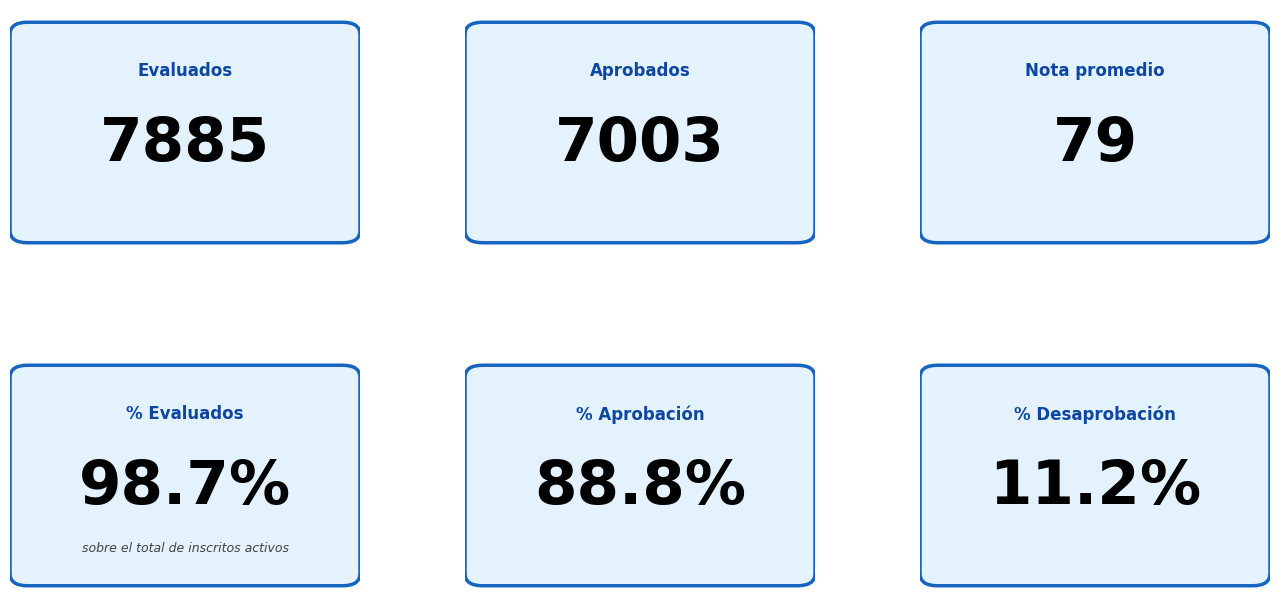

In [53]:
fig_tarjeta_cuestionarios=crear_grafico_cards(datos_cuestionarios, titulo_general="", filas=2, columnas=3)

# Guardar en biblioteca
biblioteca['Calificaciones'].append({
    'name': 'Tarjetas de calificaciones',
    'fig': fig_tarjeta_cuestionarios,
    'df': pd.DataFrame(datos_cuestionarios)
})



In [54]:
resumen_entregas = df_base_entregas.groupby(['evaluation_name', 'tipo_actividad']).agg(
    cantidad_estudiantes=('cantidad_integrantes', 'sum'),
    cantidad_entregas=('evaluation_name', 'count'),
    cantidad_destacadas=('destacado', lambda x: (x == 'Destacado').sum()),
    cantidad_sobresalientes=('sobresaliente', lambda x: (x == 'Sobresaliente').sum())
).reset_index()

resumen_entregas['% Destacadas'] = round(
    (resumen_entregas['cantidad_destacadas'] / resumen_entregas['cantidad_entregas']) * 100, 1
)

resumen_entregas['% Sobresalientes'] = round(
    (resumen_entregas['cantidad_sobresalientes'] / resumen_entregas['cantidad_entregas']) * 100, 1
)

resumen_entregas.columns = ['Evaluación', 'Tipo de actividad', 'Cant. de Estudiantes con entrega', 'Cant. de entregas Ind/Gru', 'Entregas destacadas', 'Entregas sobresalientes', '% Destacadas', '% Sobresalientes']

resumen_entregas=pd.merge (resumen_entregas, df_base_alumnos_actividad, left_on='Evaluación' ,right_on='actividad', how='inner')

resumen_entregas['% Entregas']=round(
    (resumen_entregas['Cant. de entregas Ind/Gru'] / resumen_entregas['cantidad']) * 100,1)

resumen_entregas.rename(columns={'cantidad':'Grupos/Estudiantes asignados'}, inplace=True)

resumen_entregas=resumen_entregas[['Evaluación', 'Tipo de actividad','Grupos/Estudiantes asignados', 'Cant. de Estudiantes con entrega', 'Cant. de entregas Ind/Gru', 'Entregas destacadas', 'Entregas sobresalientes','% Entregas', '% Destacadas', '% Sobresalientes']]

# Guardar en biblioteca
biblioteca['Calificaciones'].append({
    'name': 'Entregas por evaluación',
    'df': pd.DataFrame(resumen_entregas)
})


resumen_entregas

,Evaluación,Tipo de actividad,Grupos/Estudiantes asignados,Cant. de Estudiantes con entrega,Cant. de entregas Ind/Gru,Entregas destacadas,Entregas sobresalientes,% Entregas,% Destacadas,% Sobresalientes
0,Examen final,Individual,7986,6235,6235,4334,0,78.1,69.5,0.0
1,Proyecto final: Hackathon,Grupal,2121,6655,1768,670,161,83.4,37.9,9.1
2,Proyecto final: Paso 3,Grupal,2122,7090,1874,579,56,88.3,30.9,3.0


# Satisfaccion

In [55]:
def crear_gauge(valor, valor_max, titulo, valor_min=0, ax=None, figsize=(6, 4), verde=80, amarillo=60):
    """
    Crea un gráfico tipo reloj (gauge) para visualizar un indicador.
    Soporta rangos positivos, negativos y mixtos.
    Para rangos con negativos, crea un velocímetro con segmentos de colores y aguja.
    
    Parámetros:
    -----------
    valor : float
        Valor actual del indicador
    valor_max : int
        Valor máximo posible
    titulo : str
        Título del gauge
    valor_min : int
        Valor mínimo posible (default: 0)
    ax : matplotlib.axes.Axes, optional
        Ejes donde dibujar. Si es None, crea una nueva figura
    figsize : tuple
        Tamaño de la figura (solo se usa si ax es None)
    verde : int
        Umbral para color verde (en porcentaje desde el mínimo)
    amarillo : int
        Umbral para color amarillo (en porcentaje desde el mínimo)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figura de matplotlib
    ax : matplotlib.axes.Axes
        Ejes de matplotlib
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Wedge
    
    # Crear nueva figura si no se proporciona ax
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
        ax.clear()
    
    # Calcular el porcentaje
    rango_total = valor_max - valor_min
    porcentaje = ((valor - valor_min) / rango_total) * 100
    
    # Radio del arco
    radius = 1
    
    # Determinar si el rango incluye valores negativos
    tiene_negativos = valor_min < 0
    tiene_positivos = valor_max > 0
    
    if tiene_negativos and tiene_positivos:
        # MODO VELOCÍMETRO con segmentos de colores y aguja
        
        # Calcular ángulos para los segmentos
        # Semicírculo de 180° (de 180° a 0°)
        angulo_inicio = 180
        angulo_fin = 0
        
        # Calcular la posición del 0 en el rango
        pos_cero = abs(valor_min) / rango_total  # Proporción donde está el 0
        angulo_cero = angulo_inicio - (pos_cero * 180)
        
        # Definir los límites de los segmentos
        # Rojo: desde el mínimo hasta valor_min + 40% del rango negativo
        # Amarillo: zona media
        # Verde: desde 60% del rango positivo hasta el máximo
        
        if valor_min < 0:
            # Límite rojo (40% del lado negativo)
            valor_limite_rojo = valor_min + (abs(valor_min))
            angulo_limite_rojo = angulo_inicio - ((valor_limite_rojo - valor_min) / rango_total * 180)
        else:
            angulo_limite_rojo = angulo_cero
        
        if valor_max > 0:
            # Límite amarillo (40% del lado positivo)
            valor_limite_amarillo = valor_max * 0.4
            angulo_limite_amarillo = angulo_inicio - ((valor_limite_amarillo - valor_min) / rango_total * 180)
        else:
            angulo_limite_amarillo = angulo_cero
        
        # Dibujar fondo gris claro
        theta_bg = np.linspace(np.radians(angulo_inicio), np.radians(angulo_fin), 100)
        x_bg = radius * np.cos(theta_bg)
        y_bg = radius * np.sin(theta_bg)
        ax.plot(x_bg, y_bg, color='#E8E8E8', linewidth=25, solid_capstyle='butt', zorder=1)
        
        # Segmento ROJO (valores negativos bajos)
        theta_rojo = np.linspace(np.radians(angulo_inicio), np.radians(angulo_limite_rojo), 100)
        x_rojo = radius * np.cos(theta_rojo)
        y_rojo = radius * np.sin(theta_rojo)
        ax.plot(x_rojo, y_rojo, color='#E53935', linewidth=25, solid_capstyle='butt', zorder=2)
        
        # Segmento AMARILLO/NARANJA (zona media)
        theta_amarillo = np.linspace(np.radians(angulo_limite_rojo), np.radians(angulo_limite_amarillo), 100)
        x_amarillo = radius * np.cos(theta_amarillo)
        y_amarillo = radius * np.sin(theta_amarillo)
        ax.plot(x_amarillo, y_amarillo, color='#FFA726', linewidth=25, solid_capstyle='butt', zorder=2)
        
        # Segmento VERDE (valores positivos altos)
        theta_verde = np.linspace(np.radians(angulo_limite_amarillo), np.radians(angulo_fin), 100)
        x_verde = radius * np.cos(theta_verde)
        y_verde = radius * np.sin(theta_verde)
        ax.plot(x_verde, y_verde, color='#66BB6A', linewidth=25, solid_capstyle='butt', zorder=2)
        
        # Calcular ángulo de la aguja según el valor
        proporcion_valor = (valor - valor_min) / rango_total
        angulo_aguja = angulo_inicio - (proporcion_valor * 180)
        angulo_aguja_rad = np.radians(angulo_aguja)
        
        # Dibujar la AGUJA
        longitud_aguja = 0.85
        x_aguja = longitud_aguja * np.cos(angulo_aguja_rad)
        y_aguja = longitud_aguja * np.sin(angulo_aguja_rad)
        
        # Base de la aguja (triángulo)
        ax.plot([0, x_aguja], [0, y_aguja], color='#2E3F5F', linewidth=4, solid_capstyle='round', zorder=4)
        
        # Círculo central
        circle = plt.Circle((0, 0), 0.08, color='#2E3F5F', zorder=5)
        ax.add_patch(circle)
        
        # Marcas en el 0
        x_cero = 1.05 * np.cos(np.radians(angulo_cero))
        y_cero = 1.05 * np.sin(np.radians(angulo_cero))
        ax.plot([x_cero * 0.88, x_cero * 1.05], [y_cero * 0.88, y_cero * 1.05], 
                color='#2E3F5F', linewidth=3, solid_capstyle='round', zorder=3)
        
        # Determinar color del valor según el segmento
        if valor < valor_limite_rojo:
            color_valor = '#E53935'
        elif valor < valor_limite_amarillo:
            color_valor = '#FFA726'
        else:
            color_valor = '#66BB6A'
        
                # Añadir el valor actual en el centro
        ax.text(
            0, 0.5, 
            f'{valor:.0f}', 
            ha='center', 
            va='center',
            fontsize=30,
            weight='bold',
            color=color_valor
        )
        
    else:
        # MODO ORIGINAL para rangos solo positivos o solo negativos
        # Configurar colores según el porcentaje
        if porcentaje >= verde:
            color_gauge = '#4CAF50'  # Verde
        elif porcentaje >= amarillo:
            color_gauge = '#FFC107'  # Amarillo
        else:
            color_gauge = '#F44336'  # Rojo
        
        # Crear el gauge - semicírculo
        theta = np.linspace(180, 0, 100)
        theta_rad = np.radians(theta)
        
        # Dibujar el fondo (gris)
        x_bg = radius * np.cos(theta_rad)
        y_bg = radius * np.sin(theta_rad)
        ax.plot(x_bg, y_bg, color='#E0E0E0', linewidth=30, solid_capstyle='round')
        
        # Dibujar el valor actual
        theta_valor = np.linspace(180, 180 - (porcentaje/100) * 180, 100)
        theta_valor_rad = np.radians(theta_valor)
        x_valor = radius * np.cos(theta_valor_rad)
        y_valor = radius * np.sin(theta_valor_rad)
        ax.plot(x_valor, y_valor, color=color_gauge, linewidth=30, solid_capstyle='round')
        
        color_valor = color_gauge

        # Añadir el valor actual en el centro
        ax.text(
            0, 0.15, 
            f'{valor:.0f}%', 
            ha='center', 
            va='center',
            fontsize=40,
            weight='bold',
            color=color_valor
        )
    
    # Configurar el aspecto del gráfico
    ax.set_xlim(-1.4, 1.4)
    ax.set_ylim(-0.3, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # # Añadir el valor actual en el centro
    # ax.text(
    #     0, 0.15, 
    #     f'{valor:.0f}', 
    #     ha='center', 
    #     va='center',
    #     fontsize=40,
    #     weight='bold',
    #     color=color_valor
    # )
    
    # Añadir el mínimo (izquierda)
    ax.text(
        -1.19, 0.05, 
        valor_min, 
        ha='center', 
        va='center',
        fontsize=12,
        weight='bold',
        color='#424242'
    )
    
    # Añadir el máximo (derecha)
    ax.text(
        1.19, 0.05, 
        valor_max, 
        ha='center', 
        va='center',
        fontsize=12,
        weight='bold',
        color='#424242'
    )
    
    # Si hay rango mixto, añadir el 0 en el centro
    if tiene_negativos and tiene_positivos:
        x_cero_texto = 0
        y_cero_texto = 1.15
        ax.text(
            x_cero_texto, y_cero_texto, 
            '0', 
            ha='center', 
            va='center',
            fontsize=11,
            weight='bold',
            color='#424242'
        )
    
    # Título arriba
    ax.text(
        0, 1.3, 
        titulo, 
        ha='center', 
        va='center',
        fontsize=16,
        weight='bold',
        color='#2E3F5F'
    )
    
    plt.tight_layout()
    return fig, ax

In [56]:
def crear_gauge_barras(df, columna_dimension, columna_valor, columna_max,
                       titulo='Satisfacción por Dimensión',
                       figsize_base=(10, 5),
                       umbrales=(80, 60)
                       ):
    """
    Crea un gráfico de barras tipo gauge para visualizar métricas con valores máximos.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos a visualizar
    columna_dimension : str
        Nombre de la columna que contiene las dimensiones/categorías
    columna_valor : str
        Nombre de la columna con los valores actuales
    columna_max : str
        Nombre de la columna con los valores máximos/objetivo
    titulo : str, optional
        Título principal del gráfico (default: 'Satisfacción por Dimensión')
    figsize_base : tuple, optional
        Tamaño base de la figura (ancho, alto_por_dimension) (default: (10, 1.8))
    umbrales : tuple, optional
        Umbrales de porcentaje para colores (excelente, bueno) (default: (80, 60))
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figura de matplotlib creada
    
    Example:
    --------
    >>> df = pd.DataFrame({
    ...     'Dimensión': ['Calidad', 'Servicio', 'Precio'],
    ...     'Puntaje promedio': [4.2, 3.8, 4.5],
    ...     'Puntaje maximo': [5, 5, 5]
    ... })
    >>> fig = crear_gauge_barras(df, 'Dimensión', 'Puntaje promedio', 'Puntaje maximo')
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    # Configuración de colores
    color_excelente = '#A8D5E2'  # Azul pastel claro
    color_bueno = '#7FB3D5'      # Azul pastel medio
    color_regular = '#5499C7'    # Azul pastel oscuro
    color_fondo = '#EBF5FB'      # Azul muy claro para fondo
    color_objetivo = '#1B4F72'   # Azul oscuro para línea objetivo
    
    # Crear figura con subplots
    n_dimensiones = len(df)
    fig, axes = plt.subplots(n_dimensiones, 1, 
                             figsize=(figsize_base[0], n_dimensiones * figsize_base[1]))
    
    # Si solo hay una dimensión, convertir axes en lista
    if n_dimensiones == 1:
        axes = [axes]
    
    # Crear cada gauge de barra
    for idx, (ax, (_, row)) in enumerate(zip(axes, df.iterrows())):
        dimension = row[columna_dimension]
        valor = row[columna_valor]
        valor_max = row[columna_max]
        
        # Calcular porcentaje
        porcentaje = (valor / valor_max) * 100
        
        # Determinar color según umbrales
        if porcentaje >= umbrales[0]:
            color_barra = color_excelente
        elif porcentaje >= umbrales[1]:
            color_barra = color_bueno
        else:
            color_barra = color_regular
        
        # Altura de la barra
        altura_barra = 0.5
        
        # Barra de fondo con esquinas redondeadas
        fondo = mpatches.FancyBboxPatch(
            (0, -altura_barra/2), valor_max, altura_barra,
            boxstyle=mpatches.BoxStyle("Round", pad=0.05),
            facecolor=color_fondo,
            edgecolor='#AED6F1',
            linewidth=1.5,
            alpha=0.8
        )
        ax.add_patch(fondo)
        
        # Barra de valor actual con esquinas redondeadas
        barra_valor = mpatches.FancyBboxPatch(
            (0, -altura_barra/2), valor, altura_barra,
            boxstyle=mpatches.BoxStyle("Round", pad=0.05),
            facecolor=color_barra,
            edgecolor='#5DADE2',
            linewidth=2
        )
        ax.add_patch(barra_valor)
        
        # Configurar ejes
        ax.set_xlim(-0.2, valor_max * 1.15)
        ax.set_ylim(-0.6, 0.6)
        ax.axis('off')
        
        # Título de la dimensión (izquierda, arriba)
        ax.text(-0.15, 0.45, dimension, 
                fontsize=13, weight='bold', color='#1B4F72', va='bottom', ha='left')
        
        # Valor actual (dentro de la barra si es posible, o al lado)
        if valor > 1.5:
            pos_x_valor = valor / 2
            color_texto_valor = 'black'
        else:
            pos_x_valor = valor + 0.15
            color_texto_valor = color_barra
        
        ax.text(pos_x_valor, 0, f'{valor:.2f}', 
                fontsize=20, weight='bold', color=color_texto_valor, 
                ha='center', va='center')
        
        # Etiqueta "Meta" en la línea
        
        # ax.text(valor_max, 0.38, f'Meta: {valor_max:.0f}', 
        #         fontsize=9, color=color_objetivo, ha='center', va='bottom',
        #         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
        #                  edgecolor=color_objetivo, alpha=0.8))
        
        # Línea separadora sutil entre dimensiones (excepto la última)
        if idx < n_dimensiones - 1:
            ax.axhline(y=-0.55, color='#D6EAF8', linewidth=1, alpha=0.5)
    
    # Título general
    fig.suptitle(titulo, fontsize=16, weight='bold', color='black', y=0.98)
    
    # Ajustar espaciado
    plt.tight_layout()
    
    return fig


## Estudiantes

In [57]:
# CSAT
csat_series = df_satisfaccion[
    df_satisfaccion['variable'].isin(['programa', 'contenido', 'docente ctc', 'aula virtual'])
]['answer_numeric'].dropna()

satisfaccion_general = (
    (csat_series.isin([4, 5]).sum() / len(csat_series)) * 100
).round(2) if len(csat_series) > 0 else np.nan

# NPS
nps_series = df_satisfaccion.loc[df_satisfaccion['variable']=='nps', 'answer_numeric'].dropna()
promotores = nps_series.isin([9, 10]).sum()
detractores = (nps_series <= 6).sum()
total = len(nps_series)
nps = ((promotores - detractores) / total * 100).round(1) if total > 0 else np.nan

# Respuestas totales
estudiantes_con_respuesta_satisfaccion = df_satisfaccion['student_id'].nunique()
porcentaje_de_estudiantes_con_respuesta_satisfaccion = round(
    (estudiantes_con_respuesta_satisfaccion / activos) * 100, 1)

In [58]:
## Distribucion por dimensión CSAT ##
distri_csat=df_satisfaccion[df_satisfaccion['variable'].isin(['programa', 'contenido', 'docente ctc', 'aula virtual'])].groupby('variable')['answer_numeric'].mean().round(2).reset_index()

distri_csat.columns=['Dimensión', 'Puntaje promedio']
distri_csat['Dimensión']=distri_csat['Dimensión'].str.title()

distri_csat['Puntaje maximo']=5
distri_csat = distri_csat.sort_values('Puntaje promedio', ascending=False).reset_index(drop=True)

# si dimension es 'Aula Virtual', cambiar a 'Campus Virtual'
distri_csat.loc[distri_csat['Dimensión']=='Aula Virtual', 'Dimensión']='Campus Virtual'

## Distribucion por grado CSAT ##
distri_csat_grado=df_satisfaccion[df_satisfaccion['variable'].isin(['programa', 'contenido', 'docente ctc', 'aula virtual'])].groupby('grade')['answer_numeric'].mean().round(2).reset_index()

distri_csat_grado.columns=['Grado', 'Puntaje promedio']
distri_csat_grado['Grado']=distri_csat_grado['Grado'].astype(int).astype(str)+'º grado'

distri_csat_grado['Puntaje maximo']=5
distri_csat_grado = distri_csat_grado.sort_values('Puntaje promedio', ascending=False).reset_index(drop=True)

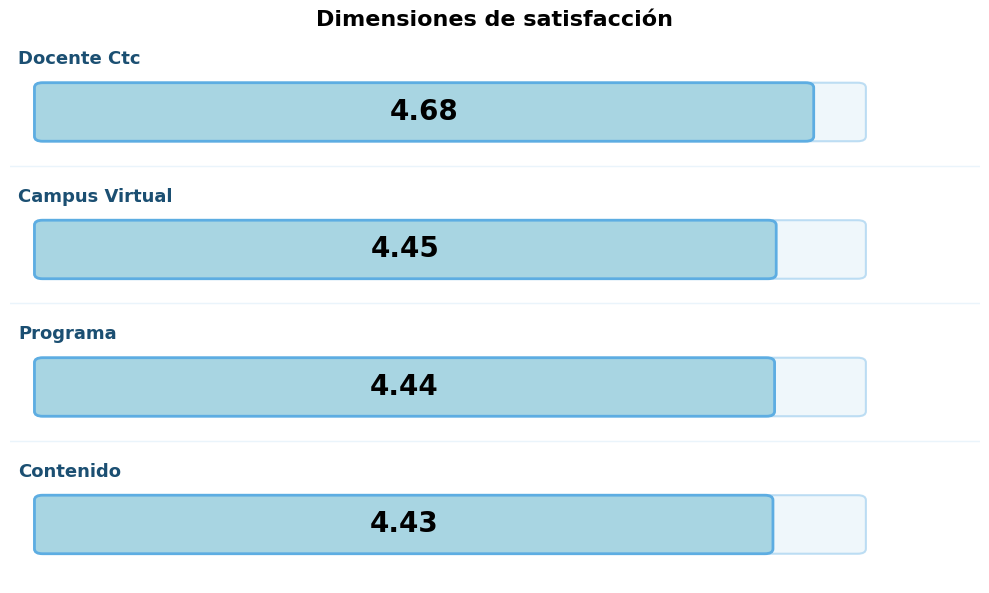

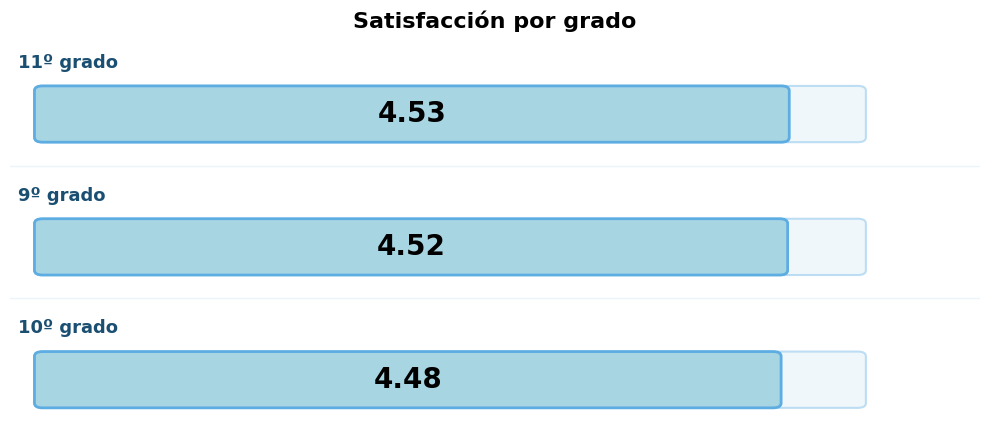

In [59]:
fig_satisfaccion_dimension=crear_gauge_barras(
    df=distri_csat,
    columna_dimension='Dimensión',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='Dimensiones de satisfacción',
    figsize_base=(10, 1.5)

)

fig_satisfaccion_grado=crear_gauge_barras(
    df=distri_csat_grado,
    columna_dimension='Grado',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='Satisfacción por grado',
    figsize_base=(10, 1.5)

)

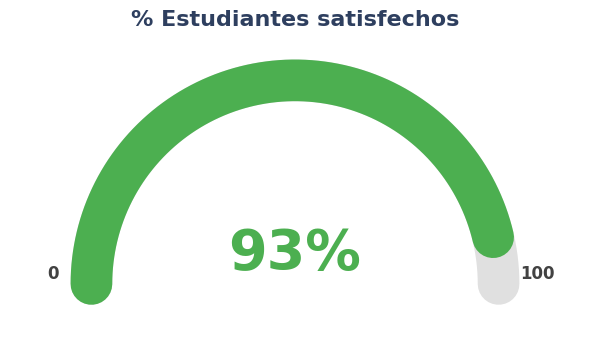

In [ ]:
# Verificar qué métricas están disponibles
metricas_disponibles = []
if pd.notna(satisfaccion_general):
    metricas_disponibles.append('satisfaccion')
if pd.notna(nps):
    metricas_disponibles.append('nps')

# Crear figura solo si hay al menos una métrica disponible
if metricas_disponibles:
    num_metricas = len(metricas_disponibles)
    fig_satisfaccion_nps, axes = plt.subplots(1, num_metricas, figsize=(6 * num_metricas, 5))
    
    # Si solo hay una métrica, axes no es un array
    if num_metricas == 1:
        axes = [axes]
    
    idx = 0
    if 'satisfaccion' in metricas_disponibles:
        crear_gauge(valor=satisfaccion_general, valor_min=0, valor_max=100, 
                    titulo='% Estudiantes satisfechos', ax=axes[idx])
        idx += 1
    
    if 'nps' in metricas_disponibles:
        crear_gauge(valor=nps, valor_min=-100, valor_max=100, 
                    titulo='NPS', ax=axes[idx], verde=50, amarillo=0)
    
    # Guardar en biblioteca
    biblioteca['Satisfaccion'].append({
        'name': 'CSAT y NPS de estudiantes',
        'fig': fig_satisfaccion_nps,
        'data': pd.DataFrame({
            'Métrica': ['Satisfacción General', 'NPS'],
            'Valor': [satisfaccion_general, nps]
        })
    })

## Profesores

In [61]:
df_satisfaccion_profesores_ie=df_satisfaccion_profesores[df_satisfaccion_profesores['tipo_profesor_respondente']=='IE']

In [62]:
# CSAT
csat_series_profe_ie = df_satisfaccion_profesores_ie['answer_numeric'].dropna()

satisfaccion_general_profe_ie = (
    (csat_series_profe_ie.isin([4, 5]).sum() / len(csat_series_profe_ie)) * 100
).round(2) if len(csat_series_profe_ie) > 0 else np.nan

distri_satisfaccion_variables_IE = df_satisfaccion_profesores_ie.dropna(subset=['answer_numeric']).groupby('variable')['answer_numeric'].mean().astype(float).round(2).reset_index()
distri_satisfaccion_variables_IE.columns=['Dimensión', 'Puntaje promedio']
distri_satisfaccion_variables_IE['Puntaje maximo']=5


distri_satisfaccion_planestudio_IE = df_satisfaccion_profesores_ie.dropna(subset=['answer_numeric']).groupby('plan_estudio')['answer_numeric'].mean().astype(float).round(2).reset_index()
distri_satisfaccion_planestudio_IE.columns=['Plan de estudio', 'Puntaje promedio']
distri_satisfaccion_planestudio_IE['Puntaje maximo']=5


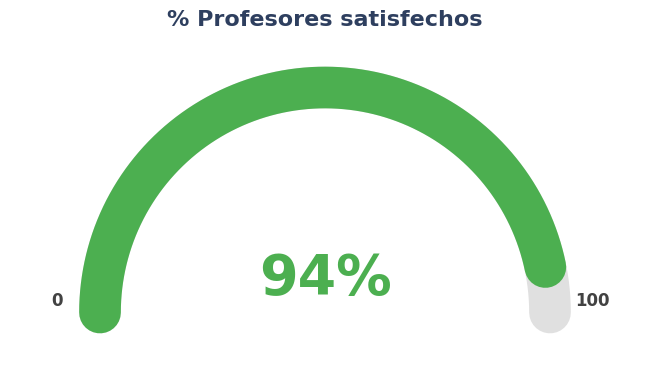

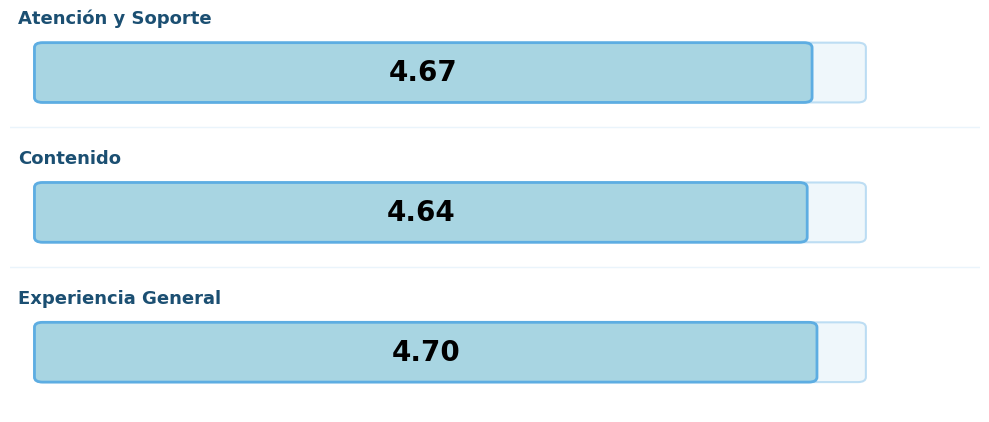

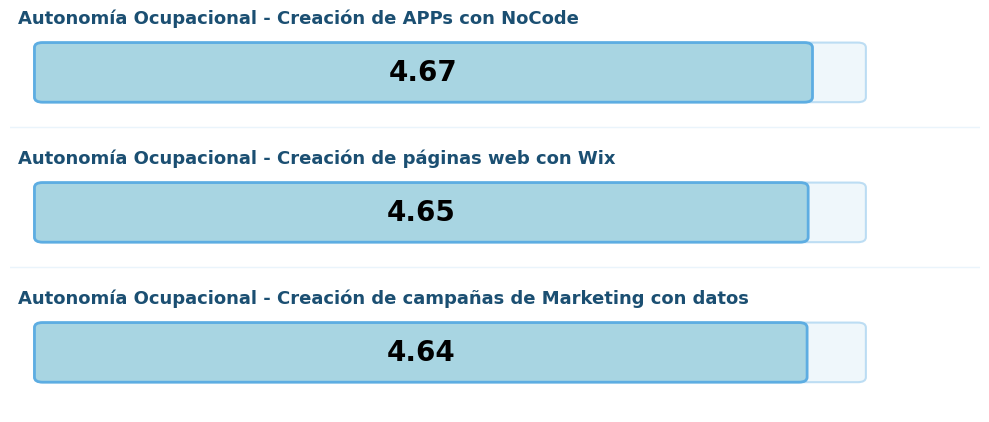

In [63]:
if len(df_satisfaccion_profesores_ie)>0:
#-----------------------------
    # Gráfico de gauge para satisfacción general de profesores IE
    fig_satisfaccion_IE, ax3 = plt.subplots(1, 1, figsize=(10, 4))
    crear_gauge(valor=satisfaccion_general_profe_ie, valor_min=0, valor_max=100, titulo='% Profesores satisfechos', ax=ax3)

    # Guardar en biblioteca
    biblioteca['Satisfaccion'].append({
        'name': 'CSAT de profesores IE',
        'fig': fig_satisfaccion_IE,
        'data': pd.DataFrame({
            'Métrica': ['Satisfacción General'],
            'Valor': [satisfaccion_general_profe_ie]
        })
    })
#-----------------------------
    # Gráfico de barras para dimensiones de satisfacción de profesores IE

    fig_satisfaccion_variables_IE=crear_gauge_barras(
    distri_satisfaccion_variables_IE,
    columna_dimension='Dimensión',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='',
    figsize_base=(10, 1.5)
    )

    # Guardar en biblioteca
    biblioteca['Satisfaccion'].append({
        'name': 'Satisfacción por dimensión de profesores IE',
        'fig': fig_satisfaccion_variables_IE,
        'data': pd.DataFrame(distri_satisfaccion_variables_IE)
    })
#-----------------------------
    # Metricas para resumen de tematicas abordadas en OC por profesores IE

    resumen_satisfaccion_OC_profe_ie=desagregar(df_satisfaccion_profesores_ie,'ofertas_academicas','answer_numeric').groupby('valor_individual')['id'].mean().reset_index()
    resumen_satisfaccion_OC_profe_ie.columns=['Tematicas abordadas', 'Puntaje promedio']
    resumen_satisfaccion_OC_profe_ie['Puntaje maximo']=5
    resumen_satisfaccion_OC_profe_ie.sort_values('Puntaje promedio', ascending=False, inplace=True)
    
    # Gráfico de barras para tematicas abordadas en OC por profesores IE
    fig_satisfaccion_planestudio_IE=crear_gauge_barras(
        resumen_satisfaccion_OC_profe_ie,
        columna_dimension='Tematicas abordadas',
        columna_valor='Puntaje promedio',
        columna_max='Puntaje maximo',
        titulo='',
        figsize_base=(10, 1.5)
    )

    # Guardar en biblioteca
    biblioteca['Satisfaccion'].append({
        'name': 'Satisfacción por grado de profesores IE',
        'fig': fig_satisfaccion_planestudio_IE,
        'data': pd.DataFrame(resumen_satisfaccion_OC_profe_ie)
    })

# Uso del campus

In [64]:
# timecreated (utc0) a hora colombia
df_uso_campus['timecreated'] = (
    pd.to_datetime(df_uso_campus['timecreated'])
    .dt.tz_localize('UTC')              # ← Primero: declarar que es UTC
    .dt.tz_convert('America/Bogota')    # ← Segundo: convertir a Colombia
)

In [65]:
df_uso_campus = df_uso_campus[df_uso_campus['moodle_id'].notnull()].copy()
df_uso_campus['timecreated'] = pd.to_datetime(df_uso_campus['timecreated'])

# Mapeo a español
dias_espanol = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}

df_uso_campus['dia_semana'] = df_uso_campus['timecreated'].dt.day_name().map(dias_espanol)
df_uso_campus['hora'] = df_uso_campus['timecreated'].dt.hour

# Agrupar por día y hora
interacciones_dia_hora = (
    df_uso_campus
    .groupby(['dia_semana', 'hora'])
    .size()
    .reset_index(name='interacciones')
)

# Calcular % usando transform
interacciones_dia_hora['% del día'] = (
    interacciones_dia_hora.groupby('dia_semana')['interacciones']
    .transform(lambda x: round((x / x.sum()) * 100, 2))
)

# Ordenar
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
interacciones_dia_hora['dia_semana'] = pd.Categorical(
    interacciones_dia_hora['dia_semana'], 
    categories=orden_dias, 
    ordered=True
)
interacciones_dia_hora = interacciones_dia_hora.sort_values(['dia_semana', 'hora'])

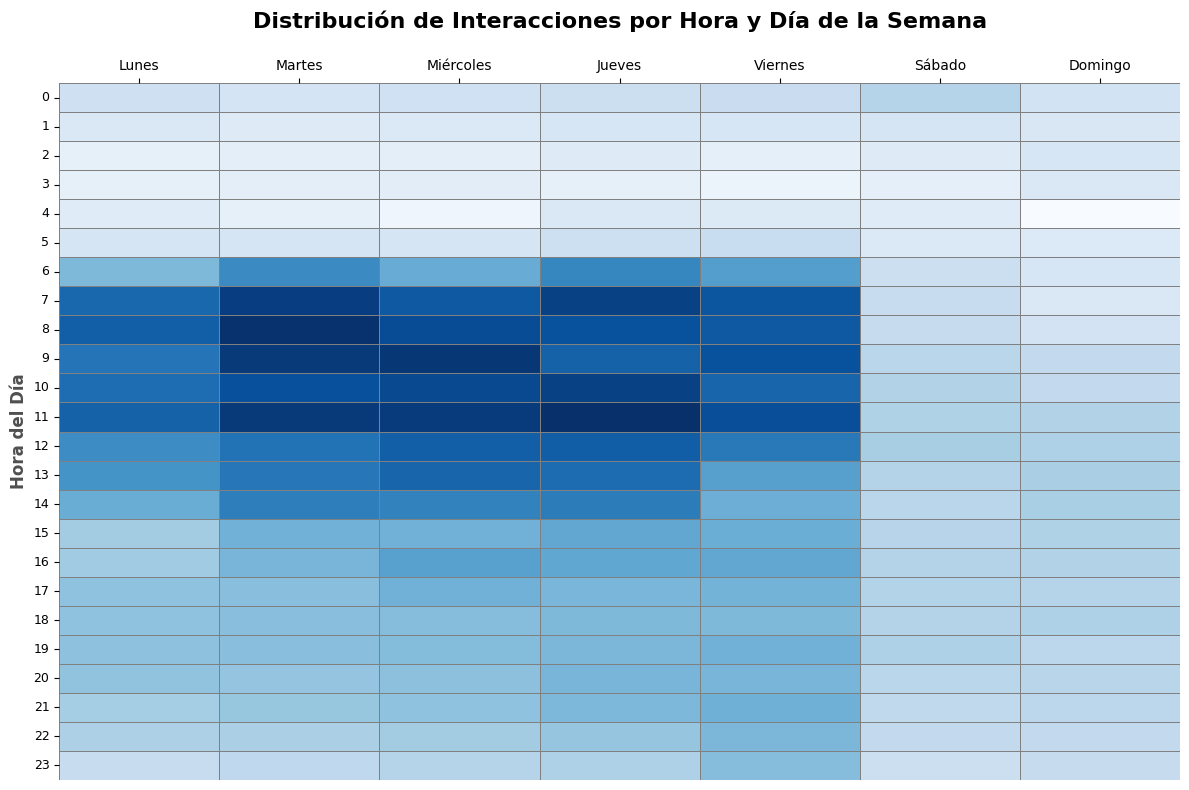

In [66]:
# Crear tabla pivoteada con total de interacciones (sin porcentajes por día)
tabla_heatmap = interacciones_dia_hora.pivot(
    index='hora',
    columns='dia_semana',
    values='interacciones'  # Total de interacciones
).fillna(0)

# Aplicar transformación logarítmica para mejor visualización
# Agregamos +1 para evitar log(0)
tabla_heatmap_log= np.power(tabla_heatmap, 0.3)

# Crear figura
fig_heatmap_campus, ax = plt.subplots(figsize=(12, 8))

# Crear heatmap con colores pasteles
sns.heatmap(
    tabla_heatmap_log,             # Usar datos transformados
    annot=False,           # Pero mostrar valores originales
    fmt='g',                       # Formato general (evita notación científica)
    cmap='Blues',                  # Paleta azul
    vmin=0,                        # Mínimo = blanco
    vmax=tabla_heatmap_log.max().max(), # Máximo automático de los datos transformados
    cbar_kws={'label': 'Total de interacciones (escala log)', 'shrink': 0.8},
    linewidths=0.5,                # Grosor de líneas
    linecolor='grey',              # Líneas grises
    square=False,                  # Celdas rectangulares
    xticklabels=True,              # Mostrar etiquetas X
    yticklabels=True,              # Mostrar etiquetas Y
    ax=ax,
    cbar=False                     # Mostrar barra de color
)

# Título
ax.set_title('Distribución de Interacciones por Hora y Día de la Semana', 
             fontsize=16, weight='bold', pad=40, color='black')

# Etiquetas de ejes
ax.set_xlabel('', fontsize=12, weight='bold', color='#4F4F4F')
ax.set_ylabel('Hora del Día', fontsize=12, weight='bold', color='#4F4F4F')

# Mover etiqueta de días a la parte SUPERIOR
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Rotar etiquetas de días (horizontal)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=10)

# Horas en horizontal (no vertical)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center', fontsize=9)

# Formatear los valores dentro de las celdas
for text in ax.texts:
    current_text = text.get_text()
    if current_text and current_text != '0':
        try:
            valor = float(current_text)
            # Formatear con separador de miles
            text.set_text(f'{int(valor):,}'.replace(',', '.'))
        except:
            pass
    text.set_fontsize(8)
    text.set_weight('normal')

plt.tight_layout()
plt.show()

# Guardar en biblioteca
biblioteca['Campus'].append({
    'name': 'Heatmap de uso del campus por día y hora',
    'fig': fig_heatmap_campus,
    'data': interacciones_dia_hora
})

In [67]:
# Alumnos activos en campus por mes
df_uso_campus['mes']=df_uso_campus['timecreated'].dt.tz_localize(None).dt.to_period('M')

alumnos_activos_mes = (
    df_uso_campus
    .groupby('mes')['moodle_id']
    .nunique()
    .reset_index()
)

alumnos_activos_mes.columns = ['Mes', 'inscritos que usaron el campus']
alumnos_activos_mes['% del total de inscritos'] = round(alumnos_activos_mes['inscritos que usaron el campus'] / alumnos_activos * 100, 1)


2025-12-11 15:07:03,293 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-11 15:07:03,296 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


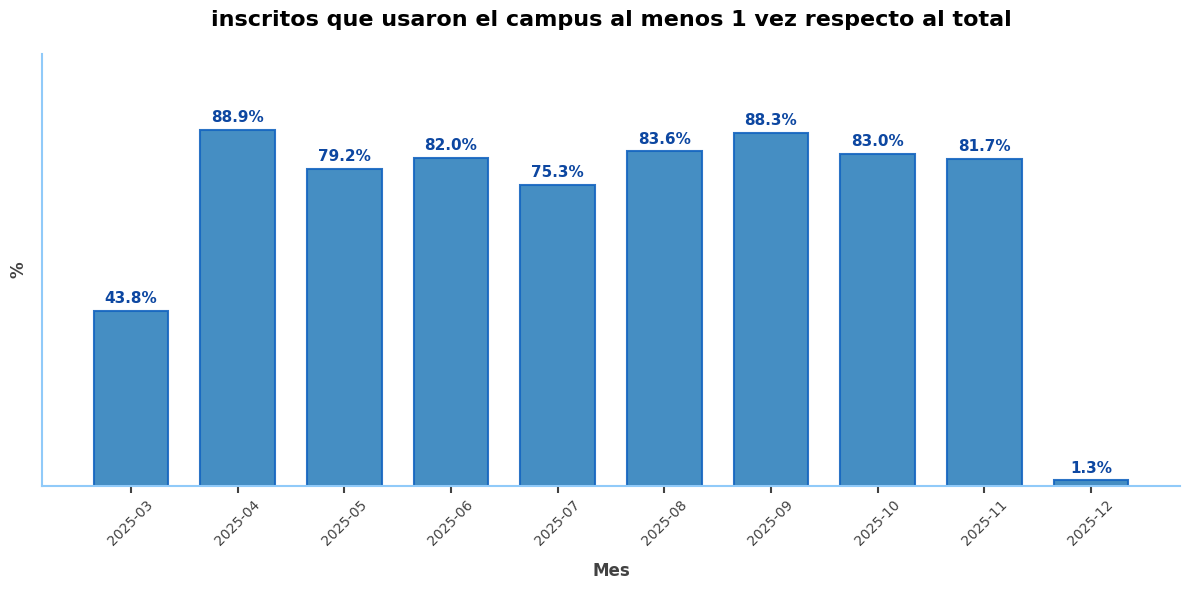

In [68]:
alumnos_activos_mes['Mes'] = alumnos_activos_mes['Mes'].astype(str)
alumnos_activos_mes.sort_values('Mes', inplace=True)

# Crear figura
fig_actividad_en_moodle_mes, ax = plt.subplots(figsize=(12, 6))
fig_actividad_en_moodle_mes.patch.set_facecolor('white')

# Color sólido profesional
color_barras = '#3182bd'

# Crear gráfico de barras
bars = ax.bar(
    alumnos_activos_mes['Mes'],
    alumnos_activos_mes['% del total de inscritos'],
    color=color_barras,
    edgecolor='#1565C0',
    linewidth=1.5,
    alpha=0.9,
    width=0.7
)

# Agregar etiquetas sobre las barras con valores
for bar, porcentaje in zip(bars, alumnos_activos_mes['% del total de inscritos']):
    altura = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        altura + 1.2,
        f'{porcentaje:.1f}%',
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold',
        color='#0D47A1'
    )

# Título principal
ax.set_title(
    'inscritos que usaron el campus al menos 1 vez respecto al total',
    fontsize=16,
    weight='bold',
    pad=20,
    color='black'
)

# Etiquetas de ejes
ax.set_xlabel('Mes', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax.set_ylabel('%', fontsize=12, weight='bold', color='#424242', labelpad=10)

# Grilla sutil para facilitar la lectura
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#BBDEFB')
ax.set_axisbelow(True)

# Estilo de los bordes (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#90CAF9')
ax.spines['bottom'].set_color('#90CAF9')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Estilo de los ticks
ax.tick_params(
    axis='x',
    colors='#424242',
    labelsize=10,
    rotation=45,
    length=5,
    width=1.5
)
ax.tick_params(
    axis='y',
    colors='#424242',
    labelsize=10,
    length=5,
    width=1.5
)
ax.set_yticks([])

# Ajustar límites del eje Y para mejor visualización
ax.set_ylim(0, 108)

# Ajustar layout para que no se corten las etiquetas
plt.tight_layout()
plt.show()

# guardar en biblioteca
biblioteca['Campus'].append({
    'name': 'Alumnos activos en campus por mes',
    'fig': fig_actividad_en_moodle_mes,
    'data': alumnos_activos_mes
})

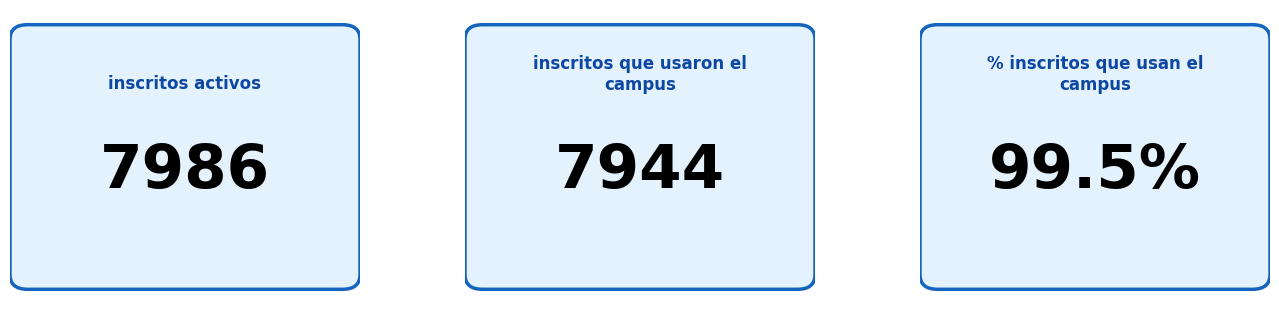

In [69]:
alumnos_activos_en_moodle = df_uso_campus['moodle_id'].nunique()
perc_alumnos_activos_en_moodle = round((alumnos_activos_en_moodle / alumnos_activos) * 100, 1)

datos_campus = [
    {
        'titulo': 'inscritos activos',
        'valor': alumnos_activos
    },
    {
        'titulo': 'inscritos que usaron el campus',
        'valor': alumnos_activos_en_moodle,
    },
    {
        'titulo': '% inscritos que usan el campus',
        'valor': perc_alumnos_activos_en_moodle,
        'sufijo': '%'
    }
    ]

fig_tarjeta_campus=crear_grafico_cards(datos_campus, titulo_general="", filas=1, columnas=3)

# Guardar en biblioteca
biblioteca['Campus'].append({
    'name': 'Tarjetas de uso del campus',
    'fig': fig_tarjeta_campus,
    'data': pd.DataFrame(datos_campus)}
    )
    

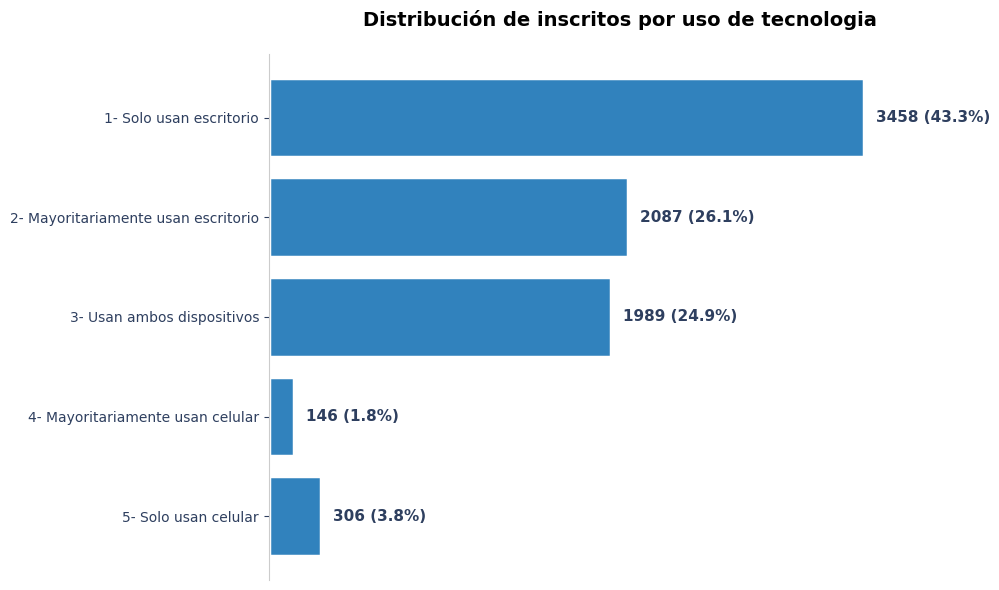

In [70]:
dist_dispositivo=df_alumnos.groupby('dispositivo')['id'].nunique().reset_index()
dist_dispositivo.columns =  ['Dispositivo', 'inscritos']
dist_dispositivo['% del total'] = (dist_dispositivo['inscritos'] / dist_dispositivo['inscritos'].sum()*100).round(1)
dist_dispositivo=dist_dispositivo.sort_values('Dispositivo')

fig_dispositivo = crear_grafico_distribucion(
    df_distribucion=dist_dispositivo,
    col_categoria='Dispositivo',
    col_cantidad='inscritos',
    titulo_grafico='Distribución de inscritos por uso de tecnologia',
    label_y='',
    colormap='#3182bd'
)

biblioteca['Campus'].append({
    'name': 'distribucion_por_dispositivo',
    'fig': fig_dispositivo,
    'df': dist_dispositivo
})

# Test de informe

In [71]:
proyecto_info=df_proyectos.iloc[0]

In [ ]:
# GENERACIÓN DE DOCUMENTO WORD CON WORD.PY

import word

# Crear el documento usando DocumentBuilder
builder = word.DocumentBuilder()


# ========================================
# INDICE
# ========================================

builder.indice()
builder.salto_pagina()

# Agregar título general del documento
builder.titulo("INFORME DE ANÁLISIS", nivel=1)

# ========================================
# INTRODUCCIÓN AL PROYECTO
# ========================================
builder.titulo("Introducción al proyecto", nivel=2)

if var_ia:

    parrafo_ia_introduccion=(ia.analyze_dataframe(
    df=(resumen_proyecto.merge(df_proyectos, left_on='Proyecto', right_on='proyecto_nombre', how='right')),
    seccion='introduccion',
    contexto='Introduccion al proyecto',
    modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_introduccion)

else:
    builder.parrafo(    
        f"Este documento presenta un análisis exhaustivo del proyecto '{proyecto_info['proyecto_nombre']}', "
        f"una iniciativa en formato {proyecto_info['formato']} "
        f"que se desarrolla del {proyecto_info['fecha_inicio_operativo']} al {proyecto_info['fecha_fin_operativo']} "
        f"({int(proyecto_info['duracion_semanas'])} semanas). "
        f"El análisis incluye información demográfica de los estudiantes, distribución por instituciones, "
        f", análisis de asistencia, clases impartidas y satisfaccion."
    )

# Resumen general del proyecto
builder.tabla(resumen_proyecto)

# Resumen por institución educativa
if tiene_instituciones:
    builder.titulo("Distribución por institución educativa", nivel=3)

    # Insertar tabla
    tabla1 = word.insertar_tabla(builder.doc, resumen_IE)
        
    # ✅ HEATMAP para % Mujeres (Durazno pastel)
    word.formato_escala_color(
        tabla1, 
        resumen_IE, 
        '% Mujeres',
        Vmin=0,
        
        color_min='FFFAF5',      # Durazno casi blanco (0%)
        color_medio='FFDDC1',    # Durazno pastel suave (50%)
        color_max='FFC8A8'       # Durazno pastel medio (100%)
    )

    # ✅ HEATMAP para % Hombres (Sky blue pastel)
    word.formato_escala_color(
        tabla1, 
        resumen_IE, 
        '% Hombres',
        Vmin=0,
        
        color_min='F7FBFF',      # Sky blue casi blanco (0%)
        color_medio='D4E9F7',    # Sky blue pastel suave (50%)
        color_max='B5D8F0'       # Sky blue pastel medio (100%)
    )

# Resumen por grado
if tiene_grados:
    builder.titulo("Distribución por grado", nivel=3)

    # Insertar tabla
    tabla1 = word.insertar_tabla(builder.doc, resumen_grado)
        
    # ✅ HEATMAP para % Mujeres (Durazno pastel)
    word.formato_escala_color(
        tabla1, 
        resumen_grado, 
        '% Mujeres',
        Vmin=0,
        
        color_min='FFFAF5',      # Durazno casi blanco (0%)
        color_medio='FFDDC1',    # Durazno pastel suave (50%)
        color_max='FFC8A8'       # Durazno pastel medio (100%)
    )

    # ✅ HEATMAP para % Hombres (Sky blue pastel)
    word.formato_escala_color(
        tabla1, 
        resumen_grado, 
        '% Hombres',
        Vmin=0,
        
        color_min='F7FBFF',      # Sky blue casi blanco (0%)
        color_medio='D4E9F7',    # Sky blue pastel suave (50%)
        color_max='B5D8F0'       # Sky blue pastel medio (100%)
    )

# ========================================
# ANÁLISIS DEMOGRÁFICO
# ========================================
builder.titulo("Análisis demográfico", nivel=2)

if var_ia:
    resumen_demografico = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Demografico']
    ]

    parrafo_ia_demografia=(ia.analyze_dataframe(
        df=resumen_demografico,
        seccion='resumen',
        contexto='Análisis Demográfico',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_demografia)



# ========================================
# ANÁLISIS DE ASISTENCIA
# ========================================
builder.titulo("Análisis de Asistencia", nivel=2)

if var_ia:
    resumen_asistencias = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Asistencias']
    ]

    parrafo_ia_asistencias=(ia.analyze_dataframe(
        df=resumen_asistencias,
        seccion='introduccion',
        contexto='Análisis de asistencias',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_asistencias)

# Asistencia general del proyecto
asistencia_proyecto_alumno = asistencia_por(df_asistencia_alumno, 'name')

builder.parrafo(
    f"El proyecto registra un porcentaje de asistencia de los alumnos del {asistencia_proyecto_alumno['% Asistencia'].iloc[0]:.1f}% "
    f"con un {asistencia_proyecto_alumno['% Falta'].iloc[0]:.1f}% de inasistencias."
)

builder.figura(fig_tarjetas_asistencias, pie="", alto_cm= 4)

builder.parrafo('A lo largo del proyecto las asistencias se vieron de la siguiente forma:')

builder.figura(fig_asistencia_alumno, pie="Figura 6: Asistencia de alumnos durante el proyecto")

# Asistencia por institución
if tiene_instituciones:
    builder.titulo("Asistencia por institución educativa", nivel=3)
    builder.parrafo(
        "A continuación se presenta el porcentaje de asistencia por cada institución educativa participante:"
    )

    tabla1 = word.insertar_tabla(builder.doc, asistencia_institucion)

    word.formato_por_umbral(
        tabla1, 
        asistencia_institucion, 
        '% Asistencia',
        umbrales=[70, 85],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-85%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        asistencia_institucion, 
        '% Falta',
        umbrales=[15, 30],       # ← INVERTIDO: < 15 verde, 15-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )

if tiene_grados:
    builder.titulo("Asistencia por grado", nivel=3)
    builder.parrafo(
        "A continuación se presenta el porcentaje de asistencia por cada grado participante:"
    )
    tabla1 = word.insertar_tabla(builder.doc, asistencia_grado)

    word.formato_por_umbral(
        tabla1, 
        asistencia_grado, 
        '% Asistencia',
        umbrales=[70, 85],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-85%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        asistencia_grado, 
        '% Falta',
        umbrales=[15, 30],       # ← INVERTIDO: < 15 verde, 15-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )

# ========================================
# ANÁLISIS DE CANCELACIONES
# ========================================

builder.titulo("Análisis de cancelaciones", nivel=2)

if var_ia:
    resumen_cancelaciones = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Cancelaciones']
    ]

    parrafo_ia_cancelaciones=(ia.analyze_dataframe(
        df=resumen_cancelaciones,
        seccion='introduccion',
        contexto='Análisis de cancelaciones',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_cancelaciones)

else:

    builder.parrafo(
        f"Durante el desarrollo del proyecto se programaron un total de {sesiones_programadas} sesiones, "
        f"de las cuales {sesiones_canceladas} fueron canceladas, representando un {porcentaje_cancelacion}% "
        f"de cancelaciones y un {porcentaje_dictado}% de sesiones efectivamente dictadas."
    )

builder.figura(fig_barra_cancelaciones, pie="")
builder.figura(fig_cancelaciones_mes, pie="Figura 7: Evolución mensual de cancelaciones de sesiones")

if len(resumen_cancelaciones_por_proyecto)>1:
    builder.parrafo(
        "El siguiente análisis muestra el resumen de cancelaciones por cada proyecto educativo:"
    )
    builder.tabla(resumen_cancelaciones_por_proyecto)

builder.titulo("Principales motivos de cancelación", nivel=3)
builder.parrafo(
    "A continuación se presenta el análisis de los 10 principales motivos de cancelación de sesiones:"
)
builder.figura(fig_top_10_cancelaciones, pie="Figura 8: Top 10 motivos de cancelación de sesiones")

if tiene_instituciones:
    builder.titulo("Cancelaciones por institución educativa", nivel=3)
    builder.parrafo(
        "El siguiente análisis muestra las instituciones educativas con mayor número de sesiones canceladas:"
    )
    tabla1 = word.insertar_tabla(builder.doc, resumen_cancelaciones_IE)

    word.formato_por_umbral(
        tabla1, 
        resumen_cancelaciones_IE, 
        '% Dictadas',
        umbrales=[80, 90],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-85%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        resumen_cancelaciones_IE, 
        '% Cancelación',
        umbrales=[10, 20.1],       # ← INVERTIDO: < 15 verde, 15-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )
    

if tiene_grados:
    builder.titulo("Cancelaciones por grado", nivel=3)
    builder.parrafo(
        "El siguiente análisis muestra los grados con mayor número de sesiones canceladas:"
    )
    tabla1 = word.insertar_tabla(builder.doc, resumen_cancelaciones_grados)

    word.formato_por_umbral(
        tabla1, 
        resumen_cancelaciones_grados, 
        '% Dictadas',
        umbrales=[80, 90],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-85%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        resumen_cancelaciones_grados, 
        '% Cancelación',
        umbrales=[10, 20.1],       # ← INVERTIDO: < 15 verde, 15-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )

# ========================================
# ANÁLISIS DE CALIFICACIONES
# ========================================

builder.titulo("Análisis de calificaciones", nivel=2)

if var_ia:
    resumen_calificaciones = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Calificaciones']
    ]

    parrafo_ia_calificaciones=(ia.analyze_dataframe(
        df=resumen_calificaciones,
        seccion='introduccion',
        contexto='Análisis de calificaciones',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_calificaciones)
else:
    builder.parrafo(
     "Se presenta el siguiente resumen del alcance y el desempeño de los estudiantes en los cuestionarios aplicados durante el proyecto:")

builder.figura(fig_tarjeta_cuestionarios, pie="")

builder.titulo("Distribución de notas", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de los estudiantes según sus rangos de notas obtenidas en los cuestionarios:"
    "Donde la nota promedio de los estudiantes aprobados fue de ## y la de estudiantes desaprobados de ##")
builder.figura(fig_distri_notas, pie="Figura 9: Distribución de alumnos por rango de notas")

if tiene_instituciones:
    builder.titulo("Desempeño por institución educativa", nivel=3)
    tabla1 = word.insertar_tabla(builder.doc, cuestionarios_institucion)
    
    word.formato_por_umbral(
        tabla1, 
        cuestionarios_institucion, 
        '% Aprobación',
        umbrales=[70, 90],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-90%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        cuestionarios_institucion, 
        '% Desaprobados',
        umbrales=[10, 30],       # ← INVERTIDO: < 10 verde, 10-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )

    word.formato_escala_color(
        tabla1, 
        cuestionarios_institucion, 
        'Nota promedio',
        Vmax=100,
        color_min='F7FBFF',      # Sky blue casi blanco (0%)
        color_medio='D4E9F7',    # Sky blue pastel suave (50%)
        color_max='B5D8F0'       # Sky blue pastel medio (100%)
    )

if tiene_grados:
    builder.titulo("Desempeño por Grado", nivel=3)
    tabla1 = word.insertar_tabla(builder.doc, cuestionarios_grado)

    word.formato_por_umbral(
        tabla1, 
        cuestionarios_grado, 
        '% Aprobación',
        umbrales=[70, 90],
        colores=[
            'FFCDD2',    # Rojo pastel (< 70%)
            'FFF9C4',    # Amarillo pastel (70-90%)
            'D5F5E3'     # Verde pastel (> 85%)
        ]
    )

    word.formato_por_umbral(
        tabla1, 
        cuestionarios_grado, 
        '% Desaprobados',
        umbrales=[10, 30],       # ← INVERTIDO: < 10 verde, 10-30 amarillo, > 30 rojo
        colores=[
            'D5F5E3',     # Verde pastel (< 15%)
            'FFF9C4',     # Amarillo pastel (15-30%)
            'FFCDD2'      # Rojo pastel (> 30%)
        ]
    )

    word.formato_escala_color(
        tabla1, 
        cuestionarios_grado, 
        'Nota promedio',
        Vmax=100,
        color_min='F7FBFF',      # Sky blue casi blanco (0%)
        color_medio='D4E9F7',    # Sky blue pastel suave (50%)
        color_max='B5D8F0'       # Sky blue pastel medio (100%)
    )


builder.titulo("Resumen de entregas individuales y grupales", nivel=3)
tabla1 = word.insertar_tabla(builder.doc, resumen_entregas)


# ========================================
# ANÁLISIS DE SATISFACCION
# ========================================

builder.titulo("Análisis de satisfacción", nivel=2)

if var_ia:
    resumen_satisfaccion = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Satisfaccion']
    ]

    parrafo_ia_satisfaccion=(ia.analyze_dataframe(
        df=resumen_satisfaccion,
        seccion='introduccion',
        contexto='Análisis de satisfaccion con el programa educativo',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_satisfaccion)
else:
    builder.parrafo(
     "Se presenta el siguiente análisis de satisfacción general y por dimensiones del proyecto educativo:")


# ========================================
# Uso del campus virtual
# ========================================

builder.titulo("Análisis de uso del campus virtual", nivel=2)
if var_ia:
    resumen_campus = [
    {k: v for k, v in item.items() if k != 'fig'}
    for item in biblioteca['Campus']
    ]

    parrafo_ia_campus=(ia.analyze_dataframe(
        df=resumen_campus,
        seccion='introduccion',
        contexto='Análisis de uso del campus virtual',
        modelo='gpt-4.1-nano'))
    
    builder.parrafo(parrafo_ia_campus)
else:
    builder.parrafo(
     "Se presenta el siguiente análisis del uso del campus virtual durante el proyecto educativo:")

builder.figura(fig_tarjeta_campus, pie="")
builder.titulo("inscritos por dispositivo de acceso", nivel=3)
builder.parrafo(
    "El siguiente análisis muestra la distribución de alumnos según el dispositivo utilizado para acceder al campus virtual:"
)
builder.figura(fig_dispositivo, pie="Figura 13: Distribución de alumnos por dispositivo con el que acceden al campus")

builder.titulo("inscritos que usaron el campus virtual por mes", nivel=3)
builder.parrafo(
    "El siguiente análisis muestra el porcentaje de inscritos que usaron el campus virtual "
    "respecto al total de inscritos:"
)
builder.figura(fig_actividad_en_moodle_mes, pie="Figura 14: inscritos que usaron el campus por mes")


builder.titulo("Distribución de interacciones por día y hora", nivel=3)
builder.parrafo(
    "El siguiente análisis muestra la distribución de interacciones en el campus virtual "
    "por hora del día y día de la semana, los colores más oscuros indican mayor cantidad de interacciones"
)
builder.figura(fig_heatmap_campus, pie="Figura 15: Heatmap de uso del campus por día y hora")

# ========================================
# CONCLUSIONES
# ========================================

if var_ia:

    builder.salto_pagina()
    
    builder.titulo("CONCLUSIONES", nivel=1)

    parrafo_conclusion=ia.analyze_dataframe(
            df=biblioteca,
            seccion='conclusion',
            contexto='conclusiones del análisis del proyecto educativo',
            tokens=2000,
            modelo='gpt-4.1',
            temperature=0.8)
    
    builder.parrafo(parrafo_conclusion)


# ========================================
# ANEXOS
# ========================================

builder.salto_pagina()
builder.titulo("Documentos adjuntos", nivel=1)

# ========================================
# ANEXO DEMOSGRÁFICO
# ========================================

# Sección: Distribución por Edad
builder.titulo("Análisis demografico", nivel=2)
builder.titulo("Distribución por rango etario", nivel=3)
builder.parrafo(
    "El análisis por rangos etarios permite identificar los grupos de edad predominantes "
    "en el proyecto. Esta información es fundamental para ajustar contenidos, metodologías "
    "y dinámicas de aprendizaje según el nivel de desarrollo de los participantes."
)
builder.figura(fig_edad, pie="Figura 1: Distribución de estudiantes por rango etario")

tabla1 = word.insertar_tabla(builder.doc, dist_edad)
word.formato_escala_color(
    tabla1, 
    dist_edad, 
    '% del total',
    Vmin=0,
    
    color_min='F7FBFF',      # Sky blue casi blanco (0%)
    color_medio='D4E9F7',    # Sky blue pastel suave (50%)
    color_max='B5D8F0'       # Sky blue pastel medio (100%)
)

# Sección: Distribución por Género
builder.titulo("Distribución por género", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de estudiantes según su género. "
    "Este indicador permite evaluar la equidad de acceso al programa y diseñar "
    "estrategias de inclusión cuando sea necesario."
)
builder.figura(fig_genero, pie="Figura 2: Distribución de estudiantes por género")
tabla1 = word.insertar_tabla(builder.doc, dist_genero)
word.formato_escala_color(
    tabla1, 
    dist_genero, 
    '% del total',
    Vmin=0,
    
    color_min='F7FBFF',      # Sky blue casi blanco (0%)
    color_medio='D4E9F7',    # Sky blue pastel suave (50%)
    color_max='B5D8F0'       # Sky blue pastel medio (100%)
)

# Sección: Distribución por Estrato Socioeconómico
builder.titulo("Distribución por estrato socioeconómico", nivel=3)
builder.parrafo(
    "La distribución por estrato socioeconómico refleja el contexto económico de los estudiantes. "
    "Este dato es relevante para comprender barreras de acceso tecnológico, diseñar políticas de apoyo "
    "y evaluar el impacto social del proyecto en poblaciones vulnerables."
)
builder.figura(fig_estrato, pie="Figura 3: Distribución de estudiantes por estrato socioeconómico")
tabla1 = word.insertar_tabla(builder.doc, dist_estrato)
word.formato_escala_color(
    tabla1, 
    dist_estrato, 
    '% del total',
    Vmin=0,
    
    color_min='F7FBFF',      # Sky blue casi blanco (0%)
    color_medio='D4E9F7',    # Sky blue pastel suave (50%)
    color_max='B5D8F0'       # Sky blue pastel medio (100%)
)

if tiene_etnia:
    # Sección: Distribución por Etnia
    builder.titulo("Distribución por etnia", nivel=3)
    builder.parrafo(
        "El análisis de diversidad étnica permite comprender la composición multicultural del proyecto "
        "y diseñar estrategias pedagógicas inclusivas que respeten y valoren la diversidad cultural."
    )
    builder.figura(fig_etnia, pie="Figura 4: Distribución de estudiantes por etnia")
    tabla1 = word.insertar_tabla(builder.doc, dist_etnia)
    word.formato_escala_color(
        tabla1, 
        dist_etnia, 
        '% del total',
        Vmin=0,
        
        color_min='F7FBFF',      # Sky blue casi blanco (0%)
        color_medio='D4E9F7',    # Sky blue pastel suave (50%)
        color_max='B5D8F0'       # Sky blue pastel medio (100%)
    )

# Sección: Distribución por Dispositivo
builder.titulo("Cuentan con los siguientes dispositivos tecnológicos", nivel=3)
builder.parrafo(
    "Se muestra los dispositivos con los que cuentan los alumnos para acceder al programa."
)
builder.figura(fig_dispositivos_personales, pie="Figura 5: Distribución de estudiantes por dispositivos")
tabla1 = word.insertar_tabla(builder.doc, dist_dispositivos_personales)
word.formato_escala_color(
    tabla1, 
    dist_dispositivos_personales, 
    '% del total',
    Vmin=0,
    
    color_min='F7FBFF',      # Sky blue casi blanco (0%)
    color_medio='D4E9F7',    # Sky blue pastel suave (50%)
    color_max='B5D8F0'       # Sky blue pastel medio (100%)
)

builder.titulo("Motivos de Cancelación", nivel=2)
builder.parrafo(
    "A continuación se presenta el análisis de los motivos de cancelación de sesiones:"
)
builder.tabla(resumen_motivos_cancalaciones)

# ========================================
# ANEXO DE SATISFACCION
# ========================================
builder.titulo("Análisis de Satisfacción", nivel=2)

builder.titulo("Satisfaccion de estudiantes", nivel=3)
builder.parrafo("Se presenta el análisis de satisfacción general y por dimensiones del proyecto educativo: "
                "El CSAT es la métrica que indica el porcentaje de estudiantes satisfechos (respuestas 4 y 5)"
                " y el NPS mide la lealtad de los estudiantes hacia el programa educativo.")
builder.figura(fig_satisfaccion_nps, alto_cm=5, pie="Figura 9: Satisfacción general de estudiantes")

builder.titulo("Satisfacción por dimensiones", nivel=4)
builder.parrafo("El siguiente análisis muestra la satisfacción promedio por cada dimensión evaluada en el cuestionario:")
builder.figura(fig_satisfaccion_dimension, alto_cm=5, pie="Figura 10: Satisfacción por dimensión")

if tiene_grados:
    builder.titulo("Satisfacción por grado", nivel=4)
    builder.parrafo("El siguiente análisis muestra la satisfacción promedio por cada grado evaluada en el cuestionario (las mismas se corresponden a promediar todas las dimensiones anteriores):")
    builder.figura(fig_satisfaccion_grado, pie="Figura 10: Satisfacción por grado")

if len(df_satisfaccion_profesores_ie)>0:
    builder.titulo("Satisfaccion de profesores", nivel=3)
    builder.parrafo("Se presenta el análisis de satisfacción general y por dimensiones de los profesores de instituciones educativas:")
    builder.figura(fig_satisfaccion_IE, pie="Figura 11: Satisfacción general de profesores IE")

    builder.titulo("Satisfacción por dimensiones", nivel=4)
    builder.parrafo("El siguiente análisis muestra la satisfacción promedio por cada dimensión evaluada en el cuestionario:")
    builder.figura(fig_satisfaccion_variables_IE, pie="Figura 12: Satisfacción por dimensión de profesores IE")

    builder.titulo("Satisfacción por ofertas academicas", nivel=4)
    builder.figura(fig_satisfaccion_planestudio_IE, pie="Figura 13: Satisfacción por ofertas academicas de profesores IE")


# Numerar todos los títulos
builder.numerar_titulos()

# Guardar el documento
ruta_salida = f"Informe general del proyecto ({projects_id}).docx"
builder.guardar(ruta_salida, verbose=True)


2025-12-11 15:07:10,398 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-11 15:07:10,431 - INFO - Tokens usados - Input: 690, Output: 379, Costo: $0.000221
2025-12-11 15:07:19,305 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-11 15:07:19,308 - INFO - Tokens usados - Input: 1137, Output: 489, Costo: $0.000309
2025-12-11 15:07:25,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-11 15:07:25,342 - INFO - Tokens usados - Input: 1363, Output: 448, Costo: $0.000316
2025-12-11 15:07:32,683 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-11 15:07:32,691 - INFO - Tokens usados - Input: 3355, Output: 476, Costo: $0.000526
2025-12-11 15:07:39,787 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-11 15:07:39,792 - INFO - Tokens usados - Input: 2334, Output

[OK] Documento guardado en: Informe general del proyecto (72).docx
[OK] Operaciones realizadas: 97
